# Machine Learning Project - Predicting NBA Shots

## Project Overview
This project uses the publically available NBA shot data available on the Kaggle repository (<a href="https://www.kaggle.com/datasets/mexwell/nba-shots">https://www.kaggle.com/datasets/mexwell/nba-shots</a>) to classify shots into made vs. miss. I will be using a variety of different models and comparing performance based on metrics such as accuracy and precision in order to determine which model has the best performance.

### Data Overview
The data was downloaded from the Kaggle link above. The link contains 20 years worth of data, however I will only be using data from the 2003-2004 and 2023-2024 seasons. Including more data from other seasons would probably lead to a more robust model, however even one season has around 190 thousand samples which should be more than sufficient for this project. I wanted to include 2 seasons that were relatively far apart to look at longer term trends that might affect the model. For example, as a casual NBA fan, I know that there are more 3-point attempts now as compared to 2003-2004, so I would expect overall make % to be lower. Scoring in general has also increased since 2003-2004, although a portion of that is due to increased free throws which the dataset does not include. I also expect the player to be a significant factor when classifying shots, and there is one player (LeBron James) who is in both the 2003-2004 and 2023-2024 data, so it will be interesting to see how that affects the models as well. I will run each model 3 times, one time for the 2003-2004 data, one time for the 2023-2024 data, and then one time on a combined dataset.



In [211]:
import scipy as sp
import scipy.stats as stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
# Set color map to have light blue background
sns.set()
import statsmodels.formula.api as smf
import statsmodels.api as sm
%matplotlib inline

# To avoid having panda display functions from truncating the columns
pd.set_option('display.max_columns', None)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

### Data Size
First I'll load the 2 datasets and look at number of samples and columns

In [212]:
df2004 = pd.read_csv('NBA_2004_Shots.csv')
df2024 = pd.read_csv('NBA_2024_Shots.csv')

df2004.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189803 entries, 0 to 189802
Data columns (total 26 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   SEASON_1        189803 non-null  int64  
 1   SEASON_2        189803 non-null  object 
 2   TEAM_ID         189803 non-null  int64  
 3   TEAM_NAME       189803 non-null  object 
 4   PLAYER_ID       189803 non-null  int64  
 5   PLAYER_NAME     189803 non-null  object 
 6   POSITION_GROUP  189803 non-null  object 
 7   POSITION        189803 non-null  object 
 8   GAME_DATE       189803 non-null  object 
 9   GAME_ID         189803 non-null  int64  
 10  HOME_TEAM       189803 non-null  object 
 11  AWAY_TEAM       189803 non-null  object 
 12  EVENT_TYPE      189803 non-null  object 
 13  SHOT_MADE       189803 non-null  bool   
 14  ACTION_TYPE     189803 non-null  object 
 15  SHOT_TYPE       189803 non-null  object 
 16  BASIC_ZONE      189803 non-null  object 
 17  ZONE_NAME 

In [213]:
df2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218701 entries, 0 to 218700
Data columns (total 26 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   SEASON_1        218701 non-null  int64  
 1   SEASON_2        218701 non-null  object 
 2   TEAM_ID         218701 non-null  int64  
 3   TEAM_NAME       218701 non-null  object 
 4   PLAYER_ID       218701 non-null  int64  
 5   PLAYER_NAME     218701 non-null  object 
 6   POSITION_GROUP  217437 non-null  object 
 7   POSITION        217437 non-null  object 
 8   GAME_DATE       218701 non-null  object 
 9   GAME_ID         218701 non-null  int64  
 10  HOME_TEAM       218701 non-null  object 
 11  AWAY_TEAM       218701 non-null  object 
 12  EVENT_TYPE      218701 non-null  object 
 13  SHOT_MADE       218701 non-null  bool   
 14  ACTION_TYPE     218701 non-null  object 
 15  SHOT_TYPE       218701 non-null  object 
 16  BASIC_ZONE      218701 non-null  object 
 17  ZONE_NAME 

In [214]:
df2004.head()

SEASON_1 SEASON_2     TEAM_ID               TEAM_NAME  PLAYER_ID  \
0      2004  2003-04  1610612747      Los Angeles Lakers        977   
1      2004  2003-04  1610612757  Portland Trail Blazers        757   
2      2004  2003-04  1610612747      Los Angeles Lakers        977   
3      2004  2003-04  1610612757  Portland Trail Blazers        757   
4      2004  2003-04  1610612757  Portland Trail Blazers        757   

        PLAYER_NAME POSITION_GROUP POSITION   GAME_DATE   GAME_ID HOME_TEAM  \
0       Kobe Bryant              G       SG  04-14-2004  20301187       POR   
1  Damon Stoudamire              G       PG  04-14-2004  20301187       POR   
2       Kobe Bryant              G       SG  04-14-2004  20301187       POR   
3  Damon Stoudamire              G       PG  04-14-2004  20301187       POR   
4  Damon Stoudamire              G       PG  04-14-2004  20301187       POR   

  AWAY_TEAM   EVENT_TYPE  SHOT_MADE         ACTION_TYPE       SHOT_TYPE  \
0       LAL    Made Shot       True           Jump Shot  3PT Field Goal   
1       LAL    Made Shot       True  Driving Layup Shot  2PT Field Goal   
2       LAL  Missed Shot      False           Jump Shot  2PT Field Goal   
3       LAL    Made Shot       True           Jump Shot  2PT Field Goal   
4       LAL  Missed Shot      False           Jump Shot  2PT Field Goal   

          BASIC_ZONE         ZONE_NAME ZONE_ABB       ZONE_RANGE  LOC_X  \
0  Above the Break 3  Left Side Center       LC          24+ ft.   20.0   
1    Restricted Area            Center        C  Less Than 8 ft.   -0.0   
2          Mid-Range  Left Side Center       LC        16-24 ft.   13.3   
3          Mid-Range         Left Side        L        16-24 ft.   16.4   
4          Mid-Range        Right Side        R        16-24 ft.  -15.8   

   LOC_Y  SHOT_DISTANCE  QUARTER  MINS_LEFT  SECS_LEFT  
0  21.35             25        6          0          0  
1   5.25              0        6          0          2  
2  24.45             23        6          0          9  
3  13.95             18        6          0         31  
4   7.85             16        6          0         55

In [215]:
df2004.describe()

SEASON_1       TEAM_ID      PLAYER_ID       GAME_ID          LOC_X  \
count  189803.0  1.898030e+05  189803.000000  1.898030e+05  189803.000000   
mean     2004.0  1.610613e+09    1530.123844  2.030059e+07       0.274000   
std         0.0  8.365408e+00     757.888105  3.434095e+02      11.110596   
min      2004.0  1.610613e+09      15.000000  2.030000e+07     -25.000000   
25%      2004.0  1.610613e+09     947.000000  2.030030e+07      -6.100000   
50%      2004.0  1.610613e+09    1730.000000  2.030059e+07       0.000000   
75%      2004.0  1.610613e+09    2200.000000  2.030089e+07       7.100000   
max      2004.0  1.610613e+09    2724.000000  2.030119e+07      24.800000   

               LOC_Y  SHOT_DISTANCE        QUARTER      MINS_LEFT  \
count  189803.000000  189803.000000  189803.000000  189803.000000   
mean       11.984399      11.595955       2.475388       5.333588   
std         8.261104       9.546158       1.138648       3.472361   
min         0.050000       0.000000       1.000000       0.000000   
25%         5.250000       0.000000       1.000000       2.000000   
50%         8.350000      13.000000       2.000000       5.000000   
75%        18.250000      19.000000       3.000000       8.000000   
max        90.850000      87.000000       7.000000      12.000000   

           SECS_LEFT  
count  189803.000000  
mean       28.669547  
std        17.466134  
min         0.000000  
25%        14.000000  
50%        29.000000  
75%        44.000000  
max        59.000000

The 2004 data contains about 190 thousand samples, while the 2024 data contains about 220 thousand. Both of the datasets have the same features (some of this information is described on the Kaggle site):<br />
SEASON_1 - The ending year of the season (ex. 2004) - Numeric<br />
SEASON_2 - The season year range (ex. 2003 - 2004) - Text, but 2 numerics<br />
TEAM_ID - The NBA API ID for the team - Numeric<br />
TEAM_NAME - The name of the team - Categorical<br />
PLAYER_ID - The NBA API ID for the player - Numeric<br />
PLAYER_NAME - The name of the player - Categorical<br />
POSITION_GROUP - The position group (ex. Point Guard and Shooting Guard grouped together as Guard) - Categorical<br />
POSITION - Player position - Categorical<br />
GAME_DATE - Date of the game - Date<br />
GAME_ID - NBA API ID for the game - Numeric<br />
HOME_TEAM - The team playing at home - Categorical<br />
AWAY_TEAM - The team playing away - Categorical<br />
EVENT_TYPE - Text of whether the shot was a make or a miss - Categorical<br />
SHOT_MADE - Whether the shot was make or a miss as a boolean - This is the classifier for the project - Bool<br />
ACTION_TYPE - General categorization of the shot (layup, slam dunk, jump shot, etc.) - Categorical<br />
SHOT_TYPE - Whether the shot was a 2 or 3 pointer - Categorical<br />
BASIC_ZONE - The court zone where the shot was taken - Categorical<br />
ZONE_NAME - The side of the court where the shot was taken - Categorical<br />
ZONE_ABB - The abbreviation of the zone - Categorical<br />
ZONE_RANGE - Distance range of the shot (ex. < 8 feet, 8 - 16 feet, etc.) - Categorical<br />
LOC_X - The X coordinate of where the shot was taken - Numeric<br />
LOC_Y - The Y coordinate of where the shot was taken - Numeric<br />
SHOT_DISTANCE - The distance from the basket - Numeric<br/>
QUARTER - Which quarter of the game the shot was taken. Overtime games will have quarter values higher than 4 (for OT, double OT, triple OT, etc.) - Numeric<br />
MINS_LEFT - How many minutes are remaining in the quarter - Numeric<br />
SECS_LEFT - How many seconds are remaining in the quarter - Numeric

### Data Cleaning
There are a number of redundant features which would lead to correlation issues if left in the dataset, so those will be removed now. Those features are:<br />
TEAM_ID, PLAYER_ID, GAME_ID - IDs from the NBA API which have no use for this project<br />
TEAM_NAME - This is an attribute of the player, aside from midseason trades, and is therefore redundant. I need this for something else, though, so I won't remove this right away<br />
SEASON_2 - The SEASON_1 attribute is enough to distinguish the datasets by year<br />
POSITION_GROUP, POSITION - These are attributes of the player, so are redundant and unnecesary<br />
GAME_DATE - Would likely lead to overfitting for games where a player had an abnormally high amount of makes / misses<br />
EVENT_TYPE - Just a friendlier text version of SHOT_MADE which is our classifier<br />
BASIC_ZONE, ZONE_NAME, ZONE_ABB, ZONE_RANGE - These are unnecessary with the LOC_X, LOC_Y, and SHOT_DISTANCE features which specify the exact location for the shot. 


In [216]:
df2004 = df2004.drop(['TEAM_ID', 'PLAYER_ID', 'GAME_ID', 'SEASON_2', 'POSITION_GROUP', 'POSITION', 'GAME_DATE', 'EVENT_TYPE', 'BASIC_ZONE', 'ZONE_NAME', 'ZONE_ABB', 'ZONE_RANGE'], axis = 1)
df2024 = df2024.drop(['TEAM_ID', 'PLAYER_ID', 'GAME_ID', 'SEASON_2', 'POSITION_GROUP', 'POSITION', 'GAME_DATE', 'EVENT_TYPE', 'BASIC_ZONE', 'ZONE_NAME', 'ZONE_ABB', 'ZONE_RANGE'], axis = 1)

df2004.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189803 entries, 0 to 189802
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   SEASON_1       189803 non-null  int64  
 1   TEAM_NAME      189803 non-null  object 
 2   PLAYER_NAME    189803 non-null  object 
 3   HOME_TEAM      189803 non-null  object 
 4   AWAY_TEAM      189803 non-null  object 
 5   SHOT_MADE      189803 non-null  bool   
 6   ACTION_TYPE    189803 non-null  object 
 7   SHOT_TYPE      189803 non-null  object 
 8   LOC_X          189803 non-null  float64
 9   LOC_Y          189803 non-null  float64
 10  SHOT_DISTANCE  189803 non-null  int64  
 11  QUARTER        189803 non-null  int64  
 12  MINS_LEFT      189803 non-null  int64  
 13  SECS_LEFT      189803 non-null  int64  
dtypes: bool(1), float64(2), int64(5), object(6)
memory usage: 19.0+ MB


In [217]:
df2004.head()

SEASON_1               TEAM_NAME       PLAYER_NAME HOME_TEAM AWAY_TEAM  \
0      2004      Los Angeles Lakers       Kobe Bryant       POR       LAL   
1      2004  Portland Trail Blazers  Damon Stoudamire       POR       LAL   
2      2004      Los Angeles Lakers       Kobe Bryant       POR       LAL   
3      2004  Portland Trail Blazers  Damon Stoudamire       POR       LAL   
4      2004  Portland Trail Blazers  Damon Stoudamire       POR       LAL   

   SHOT_MADE         ACTION_TYPE       SHOT_TYPE  LOC_X  LOC_Y  SHOT_DISTANCE  \
0       True           Jump Shot  3PT Field Goal   20.0  21.35             25   
1       True  Driving Layup Shot  2PT Field Goal   -0.0   5.25              0   
2      False           Jump Shot  2PT Field Goal   13.3  24.45             23   
3       True           Jump Shot  2PT Field Goal   16.4  13.95             18   
4      False           Jump Shot  2PT Field Goal  -15.8   7.85             16   

   QUARTER  MINS_LEFT  SECS_LEFT  
0        6          0          0  
1        6          0          2  
2        6          0          9  
3        6          0         31  
4        6          0         55

In [218]:
df2004.describe()

SEASON_1          LOC_X          LOC_Y  SHOT_DISTANCE        QUARTER  \
count  189803.0  189803.000000  189803.000000  189803.000000  189803.000000   
mean     2004.0       0.274000      11.984399      11.595955       2.475388   
std         0.0      11.110596       8.261104       9.546158       1.138648   
min      2004.0     -25.000000       0.050000       0.000000       1.000000   
25%      2004.0      -6.100000       5.250000       0.000000       1.000000   
50%      2004.0       0.000000       8.350000      13.000000       2.000000   
75%      2004.0       7.100000      18.250000      19.000000       3.000000   
max      2004.0      24.800000      90.850000      87.000000       7.000000   

           MINS_LEFT      SECS_LEFT  
count  189803.000000  189803.000000  
mean        5.333588      28.669547  
std         3.472361      17.466134  
min         0.000000       0.000000  
25%         2.000000      14.000000  
50%         5.000000      29.000000  
75%         8.000000      44.000000  
max        12.000000      59.000000

There aren't any NaNs or null values and the data types for the remaining features are all correct. I would like to add a feature to replace the HOME_TEAM and AWAY_TEAM with a single feature indicating if the player that took the shot is playing at home in order to better suggest the relation between a player playing at home having a positive effect on their shot percentage. Unfortunately the HOME_TEAM and AWAY_TEAM use the 3 letter abbreviation while the TEAM_NAME uses the full team name, so this is a bit cumbersome. After creating the IS_HOME feature I can drop HOME_TEAM, AWAY_TEAM, and TEAM_NAME.

In [219]:
# Use .agg() to get the most common HOME_TEAM value for each TEAM_NAME - this will be the translation between TEAM_NAME and HOME_TEAM
translation2004 = df2004.groupby('TEAM_NAME')['HOME_TEAM'].agg(pd.Series.mode).to_dict()
translation2024 = df2024.groupby('TEAM_NAME')['HOME_TEAM'].agg(pd.Series.mode).to_dict()
#print(translation2004)
#print(translation2024)

# create the IS_HOME feature and populate it using the dictionary
df2004['IS_HOME'] = df2004.apply(lambda x: translation2004[x['TEAM_NAME']] == x['HOME_TEAM'], axis=1)
df2024['IS_HOME'] = df2024.apply(lambda x: translation2024[x['TEAM_NAME']] == x['HOME_TEAM'], axis=1)

# drop unneeded features
df2004 = df2004.drop(['HOME_TEAM', 'AWAY_TEAM', 'TEAM_NAME'], axis = 1)
df2024 = df2024.drop(['HOME_TEAM', 'AWAY_TEAM', 'TEAM_NAME'], axis = 1)

#df2004.info()
df2004.head()

SEASON_1       PLAYER_NAME  SHOT_MADE         ACTION_TYPE       SHOT_TYPE  \
0      2004       Kobe Bryant       True           Jump Shot  3PT Field Goal   
1      2004  Damon Stoudamire       True  Driving Layup Shot  2PT Field Goal   
2      2004       Kobe Bryant      False           Jump Shot  2PT Field Goal   
3      2004  Damon Stoudamire       True           Jump Shot  2PT Field Goal   
4      2004  Damon Stoudamire      False           Jump Shot  2PT Field Goal   

   LOC_X  LOC_Y  SHOT_DISTANCE  QUARTER  MINS_LEFT  SECS_LEFT  IS_HOME  
0   20.0  21.35             25        6          0          0    False  
1   -0.0   5.25              0        6          0          2     True  
2   13.3  24.45             23        6          0          9    False  
3   16.4  13.95             18        6          0         31     True  
4  -15.8   7.85             16        6          0         55     True

I want to change SHOT_TYPE from a categorical variable to a numeric one, as the only values are '3PT Field Goal' and '2PT Field Goal'. This new variable will be IS_THREE indicating if the shot was a 3-pointer.

In [220]:
print(df2004['SHOT_TYPE'].unique())

df2004['IS_THREE'] = df2004.apply(lambda x: x['SHOT_TYPE'][0] == '3', axis=1)
df2024['IS_THREE'] = df2024.apply(lambda x: x['SHOT_TYPE'][0] == '3', axis=1)

df2004 = df2004.drop('SHOT_TYPE', axis = 1)
df2024 = df2024.drop('SHOT_TYPE', axis = 1)

df2004.head()

['3PT Field Goal' '2PT Field Goal']


SEASON_1       PLAYER_NAME  SHOT_MADE         ACTION_TYPE  LOC_X  LOC_Y  \
0      2004       Kobe Bryant       True           Jump Shot   20.0  21.35   
1      2004  Damon Stoudamire       True  Driving Layup Shot   -0.0   5.25   
2      2004       Kobe Bryant      False           Jump Shot   13.3  24.45   
3      2004  Damon Stoudamire       True           Jump Shot   16.4  13.95   
4      2004  Damon Stoudamire      False           Jump Shot  -15.8   7.85   

   SHOT_DISTANCE  QUARTER  MINS_LEFT  SECS_LEFT  IS_HOME  IS_THREE  
0             25        6          0          0    False      True  
1              0        6          0          2     True     False  
2             23        6          0          9    False     False  
3             18        6          0         31     True     False  
4             16        6          0         55     True     False

Next, I will merge the 2 datasets and then drop the SEASON_1 feature on the individual datasets, since it has the same value for all samples (either 2004 or 2024). I'll also rename it to YEAR on the merged dataset to give it a more useful name.

In [221]:
# create a merged dataset
df_merged = pd.concat([df2004, df2024]).rename({'SEASON_1' : 'YEAR'}, axis = 1)

df2004 = df2004.drop(['SEASON_1'], axis = 1)
df2024 = df2024.drop(['SEASON_1'], axis = 1)

Finally, I'll need to convert the remaining categorical features (PLAYER_NAME and ACTION_TYPE) into numeric values in order for them to work with the models. This wasn't something we covered in class, however I referred to online resources such as <a href="https://datasciencedojo.com/blog/categorical-data-encoding/">https://datasciencedojo.com/blog/categorical-data-encoding/</a>. I elected to go with dummy encoding, which will create a new column for each category value. While this will create a large number additional columns, other encoding methods assign numeric values to the category values, which implies an ordering even though player names are non ordinal. If LeBron James is encoded as 247 and Kobe Bryant is encoded as 248, I don't want the model to try suggesting that players in the range 247-248 tend to make more shots, that doesn't make sense in the real world application.

In [222]:
# Want to make a copy of the original dataset before adding dummies
df2004_original = df2004.copy()

df2004 = pd.get_dummies(df2004, columns=['PLAYER_NAME'])
df2004 = pd.get_dummies(df2004, columns=['ACTION_TYPE'])

df2024 = pd.get_dummies(df2024, columns=['PLAYER_NAME'])
df2024 = pd.get_dummies(df2024, columns=['ACTION_TYPE'])

df_merged = pd.get_dummies(df_merged, columns=['PLAYER_NAME'])
df_merged = pd.get_dummies(df_merged, columns=['ACTION_TYPE'])

## Final Datasets

### 2004

In [138]:
df2004.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189803 entries, 0 to 189802
Columns: 478 entries, SHOT_MADE to ACTION_TYPE_Turnaround Jump Shot
dtypes: bool(472), float64(2), int64(4)
memory usage: 94.1 MB


In [139]:
df2004.head()

SHOT_MADE  LOC_X  LOC_Y  SHOT_DISTANCE  QUARTER  MINS_LEFT  SECS_LEFT  \
0       True   20.0  21.35             25        6          0          0   
1       True   -0.0   5.25              0        6          0          2   
2      False   13.3  24.45             23        6          0          9   
3       True   16.4  13.95             18        6          0         31   
4      False  -15.8   7.85             16        6          0         55   

   IS_HOME  IS_THREE  PLAYER_NAME_Aaron McKie  PLAYER_NAME_Aaron Williams  \
0    False      True                    False                       False   
1     True     False                    False                       False   
2    False     False                    False                       False   
3     True     False                    False                       False   
4     True     False                    False                       False   

   PLAYER_NAME_Adonal Foyle  PLAYER_NAME_Adrian Griffin  \
0                     False                       False   
1                     False                       False   
2                     False                       False   
3                     False                       False   
4                     False                       False   

   PLAYER_NAME_Al Harrington  PLAYER_NAME_Alan Henderson  \
0                      False                       False   
1                      False                       False   
2                      False                       False   
3                      False                       False   
4                      False                       False   

   PLAYER_NAME_Alex Garcia  PLAYER_NAME_Allan Houston  \
0                    False                      False   
1                    False                      False   
2                    False                      False   
3                    False                      False   
4                    False                      False   

   PLAYER_NAME_Allen Iverson  PLAYER_NAME_Alonzo Mourning  \
0                      False                        False   
1                      False                        False   
2                      False                        False   
3                      False                        False   
4                      False                        False   

   PLAYER_NAME_Alton Ford  PLAYER_NAME_Alvin Williams  \
0                   False                       False   
1                   False                       False   
2                   False                       False   
3                   False                       False   
4                   False                       False   

   PLAYER_NAME_Amal McCaskill  PLAYER_NAME_Amar'e Stoudemire  \
0                       False                          False   
1                       False                          False   
2                       False                          False   
3                       False                          False   
4                       False                          False   

   PLAYER_NAME_Andre Miller  PLAYER_NAME_Andrei Kirilenko  \
0                     False                         False   
1                     False                         False   
2                     False                         False   
3                     False                         False   
4                     False                         False   

   PLAYER_NAME_Andrew DeClercq  PLAYER_NAME_Anfernee Hardaway  \
0                        False                          False   
1                        False                          False   
2                        False                          False   
3                        False                          False   
4                        False                          False   

   PLAYER_NAME_Ansu Sesay  PLAYER_NAME_Antawn Jamison  \
0                   False                       False   
1                   False                       False   


### 2024

In [140]:
df2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218701 entries, 0 to 218700
Columns: 625 entries, SHOT_MADE to ACTION_TYPE_Turnaround Jump Shot
dtypes: bool(619), float64(2), int64(4)
memory usage: 139.1 MB


In [141]:
df2024.head()

SHOT_MADE  LOC_X  LOC_Y  SHOT_DISTANCE  QUARTER  MINS_LEFT  SECS_LEFT  \
0      False   -0.4  17.45             12        1         11          1   
1       True    1.5  30.55             25        1         10         26   
2       True   -3.3   6.55              3        1          9         46   
3       True   -1.0   5.85              1        1          8         30   
4       True   -0.0   6.25              1        1          8          8   

   IS_HOME  IS_THREE  PLAYER_NAME_A.J. Lawson  PLAYER_NAME_AJ Green  \
0    False     False                    False                 False   
1    False      True                    False                 False   
2    False     False                    False                 False   
3    False     False                    False                 False   
4    False     False                    False                 False   

   PLAYER_NAME_AJ Griffin  PLAYER_NAME_Aaron Gordon  \
0                   False                     False   
1                   False                     False   
2                   False                     False   
3                   False                     False   
4                   False                     False   

   PLAYER_NAME_Aaron Holiday  PLAYER_NAME_Aaron Nesmith  \
0                      False                      False   
1                      False                      False   
2                      False                      False   
3                      False                      False   
4                      False                      False   

   PLAYER_NAME_Aaron Wiggins  PLAYER_NAME_Adam Flagler  \
0                      False                     False   
1                      False                     False   
2                      False                     False   
3                      False                     False   
4                      False                     False   

   PLAYER_NAME_Adama Sanogo  PLAYER_NAME_Admiral Schofield  \
0                     False                          False   
1                     False                          False   
2                     False                          False   
3                     False                          False   
4                     False                          False   

   PLAYER_NAME_Al Horford  PLAYER_NAME_Alec Burks  \
0                   False                   False   
1                   False                   False   
2                   False                   False   
3                   False                   False   
4                   False                   False   

   PLAYER_NAME_Aleksej Pokusevski  PLAYER_NAME_Alex Caruso  \
0                           False                    False   
1                           False                    False   
2                           False                    False   
3                           False                    False   
4                           False                    False   

   PLAYER_NAME_Alex Fudge  PLAYER_NAME_Alex Len  PLAYER_NAME_Alondes Williams  \
0                   False                 False                         False   
1                   False                 False                         False   
2                   False                 False                         False   
3                   False                 False                         False   
4                   False                 False                         False   

   PLAYER_NAME_Alperen Sengun  PLAYER_NAME_Amari Bailey  \
0                       False                     False   
1                       False                     False   
2                       False                     False   
3                       False                     False   
4                       False                     False   

   PLAYER_NAME_Amen Thompson  PLAYER_NAME_Amir Coffey  \
0                      False                    False   
1                      False                    False   
2     

### Merged

In [142]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 408504 entries, 0 to 218700
Columns: 1075 entries, YEAR to ACTION_TYPE_Turnaround Jump Shot
dtypes: bool(1068), float64(2), int64(5)
memory usage: 441.0 MB


In [143]:
df_merged.head()

YEAR  SHOT_MADE  LOC_X  LOC_Y  SHOT_DISTANCE  QUARTER  MINS_LEFT  \
0  2004       True   20.0  21.35             25        6          0   
1  2004       True   -0.0   5.25              0        6          0   
2  2004      False   13.3  24.45             23        6          0   
3  2004       True   16.4  13.95             18        6          0   
4  2004      False  -15.8   7.85             16        6          0   

   SECS_LEFT  IS_HOME  IS_THREE  PLAYER_NAME_A.J. Lawson  \
0          0    False      True                    False   
1          2     True     False                    False   
2          9    False     False                    False   
3         31     True     False                    False   
4         55     True     False                    False   

   PLAYER_NAME_AJ Green  PLAYER_NAME_AJ Griffin  PLAYER_NAME_Aaron Gordon  \
0                 False                   False                     False   
1                 False                   False                     False   
2                 False                   False                     False   
3                 False                   False                     False   
4                 False                   False                     False   

   PLAYER_NAME_Aaron Holiday  PLAYER_NAME_Aaron McKie  \
0                      False                    False   
1                      False                    False   
2                      False                    False   
3                      False                    False   
4                      False                    False   

   PLAYER_NAME_Aaron Nesmith  PLAYER_NAME_Aaron Wiggins  \
0                      False                      False   
1                      False                      False   
2                      False                      False   
3                      False                      False   
4                      False                      False   

   PLAYER_NAME_Aaron Williams  PLAYER_NAME_Adam Flagler  \
0                       False                     False   
1                       False                     False   
2                       False                     False   
3                       False                     False   
4                       False                     False   

   PLAYER_NAME_Adama Sanogo  PLAYER_NAME_Admiral Schofield  \
0                     False                          False   
1                     False                          False   
2                     False                          False   
3                     False                          False   
4                     False                          False   

   PLAYER_NAME_Adonal Foyle  PLAYER_NAME_Adrian Griffin  \
0                     False                       False   
1                     False                       False   
2                     False                       False   
3                     False                       False   
4                     False                       False   

   PLAYER_NAME_Al Harrington  PLAYER_NAME_Al Horford  \
0                      False                   False   
1                      False                   False   
2                      False                   False   
3                      False                   False   
4                      False                   False   

   PLAYER_NAME_Alan Henderson  PLAYER_NAME_Alec Burks  \
0                       False                   False   
1                       False                   False   
2                       False                   False   
3                       False                   False   
4                       False                   False   

   PLAYER_NAME_Aleksej Pokusevski  PLAYER_NAME_Alex Caruso  \
0                           False                    False   
1                           False                    False   
2                           False                    False   
3                           False          

### EDA
I'll look at the heatmaps and the pairplots for the 3 datasets. The pairplots wouldn't generate due to the large number of samples, so I limited the pairplots to 2000 samples selected at random. I also excluded the dummies for PLAYER_NAME and ACTION_TYPE, as they would make the correlation matrix unreadable.

### 2004

In [145]:
df2004.iloc[:,:9].corr()

SHOT_MADE     LOC_X     LOC_Y  SHOT_DISTANCE   QUARTER  \
SHOT_MADE       1.000000  0.001036 -0.127232      -0.174022 -0.021926   
LOC_X           0.001036  1.000000 -0.019886       0.021940 -0.002568   
LOC_Y          -0.127232 -0.019886  1.000000       0.738808  0.030515   
SHOT_DISTANCE  -0.174022  0.021940  0.738808       1.000000  0.035961   
QUARTER        -0.021926 -0.002568  0.030515       0.035961  1.000000   
MINS_LEFT       0.018065 -0.000134 -0.042866      -0.038349 -0.029174   
SECS_LEFT       0.017274  0.003379 -0.047159      -0.039899 -0.000277   
IS_HOME         0.012838 -0.003733 -0.014710      -0.017539 -0.003770   
IS_THREE       -0.088407  0.012571  0.504372       0.663286  0.063632   

               MINS_LEFT  SECS_LEFT   IS_HOME  IS_THREE  
SHOT_MADE       0.018065   0.017274  0.012838 -0.088407  
LOC_X          -0.000134   0.003379 -0.003733  0.012571  
LOC_Y          -0.042866  -0.047159 -0.014710  0.504372  
SHOT_DISTANCE  -0.038349  -0.039899 -0.017539  0.663286  
QUARTER        -0.029174  -0.000277 -0.003770  0.063632  
MINS_LEFT       1.000000   0.009494  0.003671 -0.067909  
SECS_LEFT       0.009494   1.000000  0.001542 -0.034844  
IS_HOME         0.003671   0.001542  1.000000 -0.003999  
IS_THREE       -0.067909  -0.034844 -0.003999  1.000000

<Axes: >

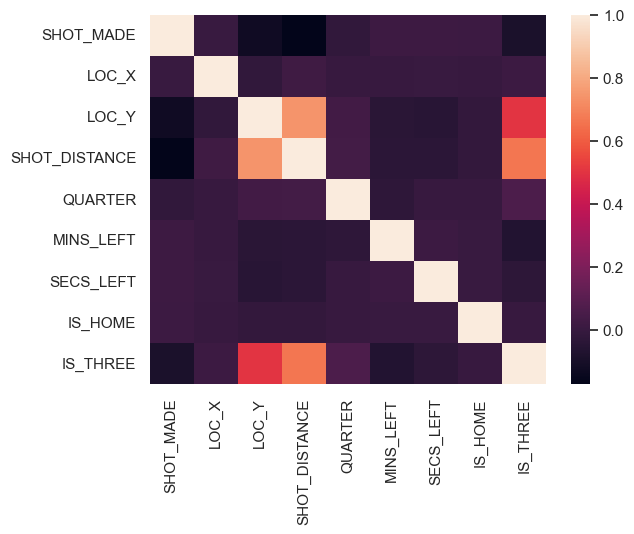

In [146]:
sns.heatmap(df2004.iloc[:,:9].corr())

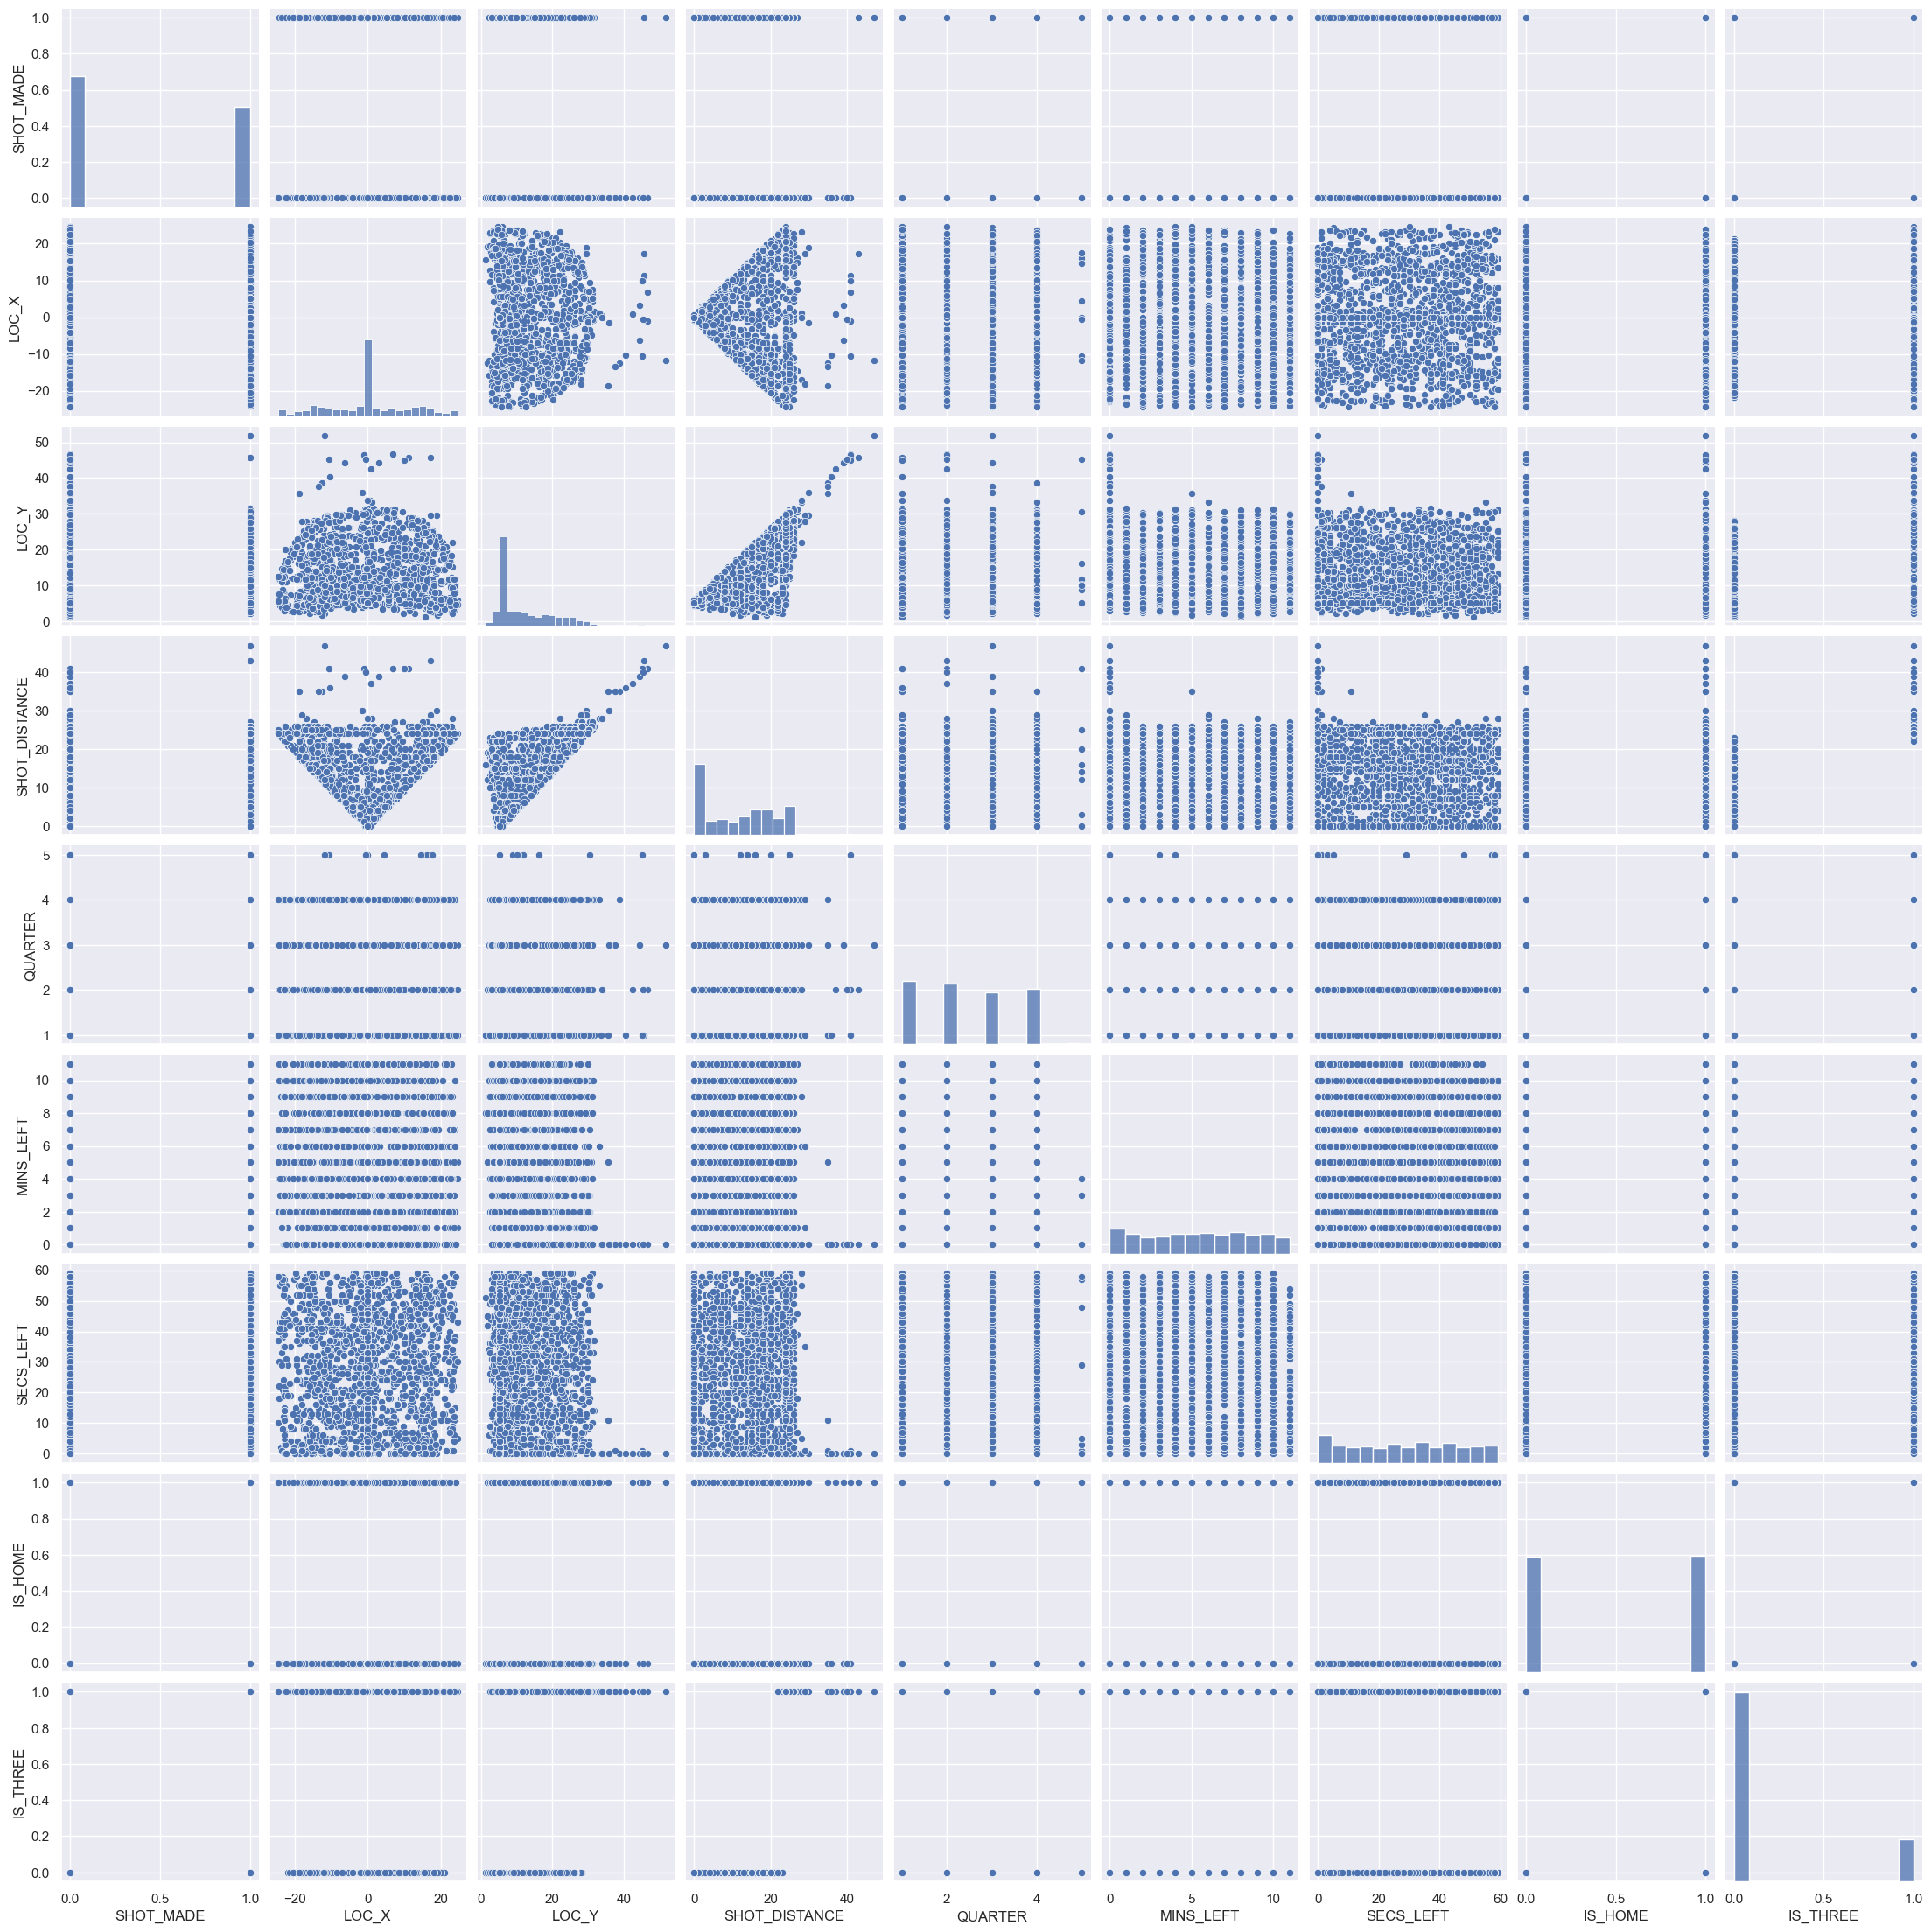

In [147]:
sns.pairplot(df2004.iloc[:,:9].sample(2000))

### 2024

In [148]:
df2024.iloc[:,:9].corr()

SHOT_MADE     LOC_X     LOC_Y  SHOT_DISTANCE   QUARTER  \
SHOT_MADE       1.000000 -0.007344 -0.182178      -0.229424 -0.005244   
LOC_X          -0.007344  1.000000  0.001518       0.026522  0.003926   
LOC_Y          -0.182178  0.001518  1.000000       0.791151 -0.005661   
SHOT_DISTANCE  -0.229424  0.026522  0.791151       1.000000 -0.004676   
QUARTER        -0.005244  0.003926 -0.005661      -0.004676  1.000000   
MINS_LEFT       0.020847 -0.002181 -0.029258      -0.027317 -0.011869   
SECS_LEFT       0.010644  0.002214 -0.030177      -0.027298  0.006675   
IS_HOME         0.007052 -0.012323 -0.006595      -0.007082  0.000072   
IS_THREE       -0.175766  0.033218  0.633785       0.890422  0.005367   

               MINS_LEFT  SECS_LEFT   IS_HOME  IS_THREE  
SHOT_MADE       0.020847   0.010644  0.007052 -0.175766  
LOC_X          -0.002181   0.002214 -0.012323  0.033218  
LOC_Y          -0.029258  -0.030177 -0.006595  0.633785  
SHOT_DISTANCE  -0.027317  -0.027298 -0.007082  0.890422  
QUARTER        -0.011869   0.006675  0.000072  0.005367  
MINS_LEFT       1.000000  -0.001772  0.000419 -0.021444  
SECS_LEFT      -0.001772   1.000000 -0.000762 -0.015757  
IS_HOME         0.000419  -0.000762  1.000000  0.003750  
IS_THREE       -0.021444  -0.015757  0.003750  1.000000

<Axes: >

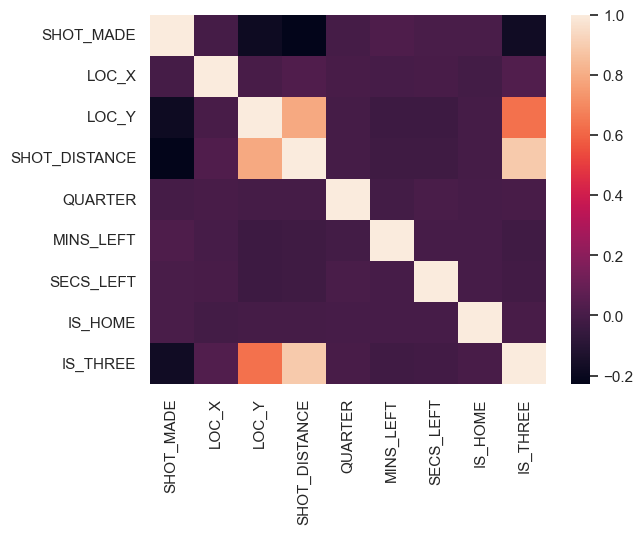

In [149]:
sns.heatmap(df2024.iloc[:,:9].corr())

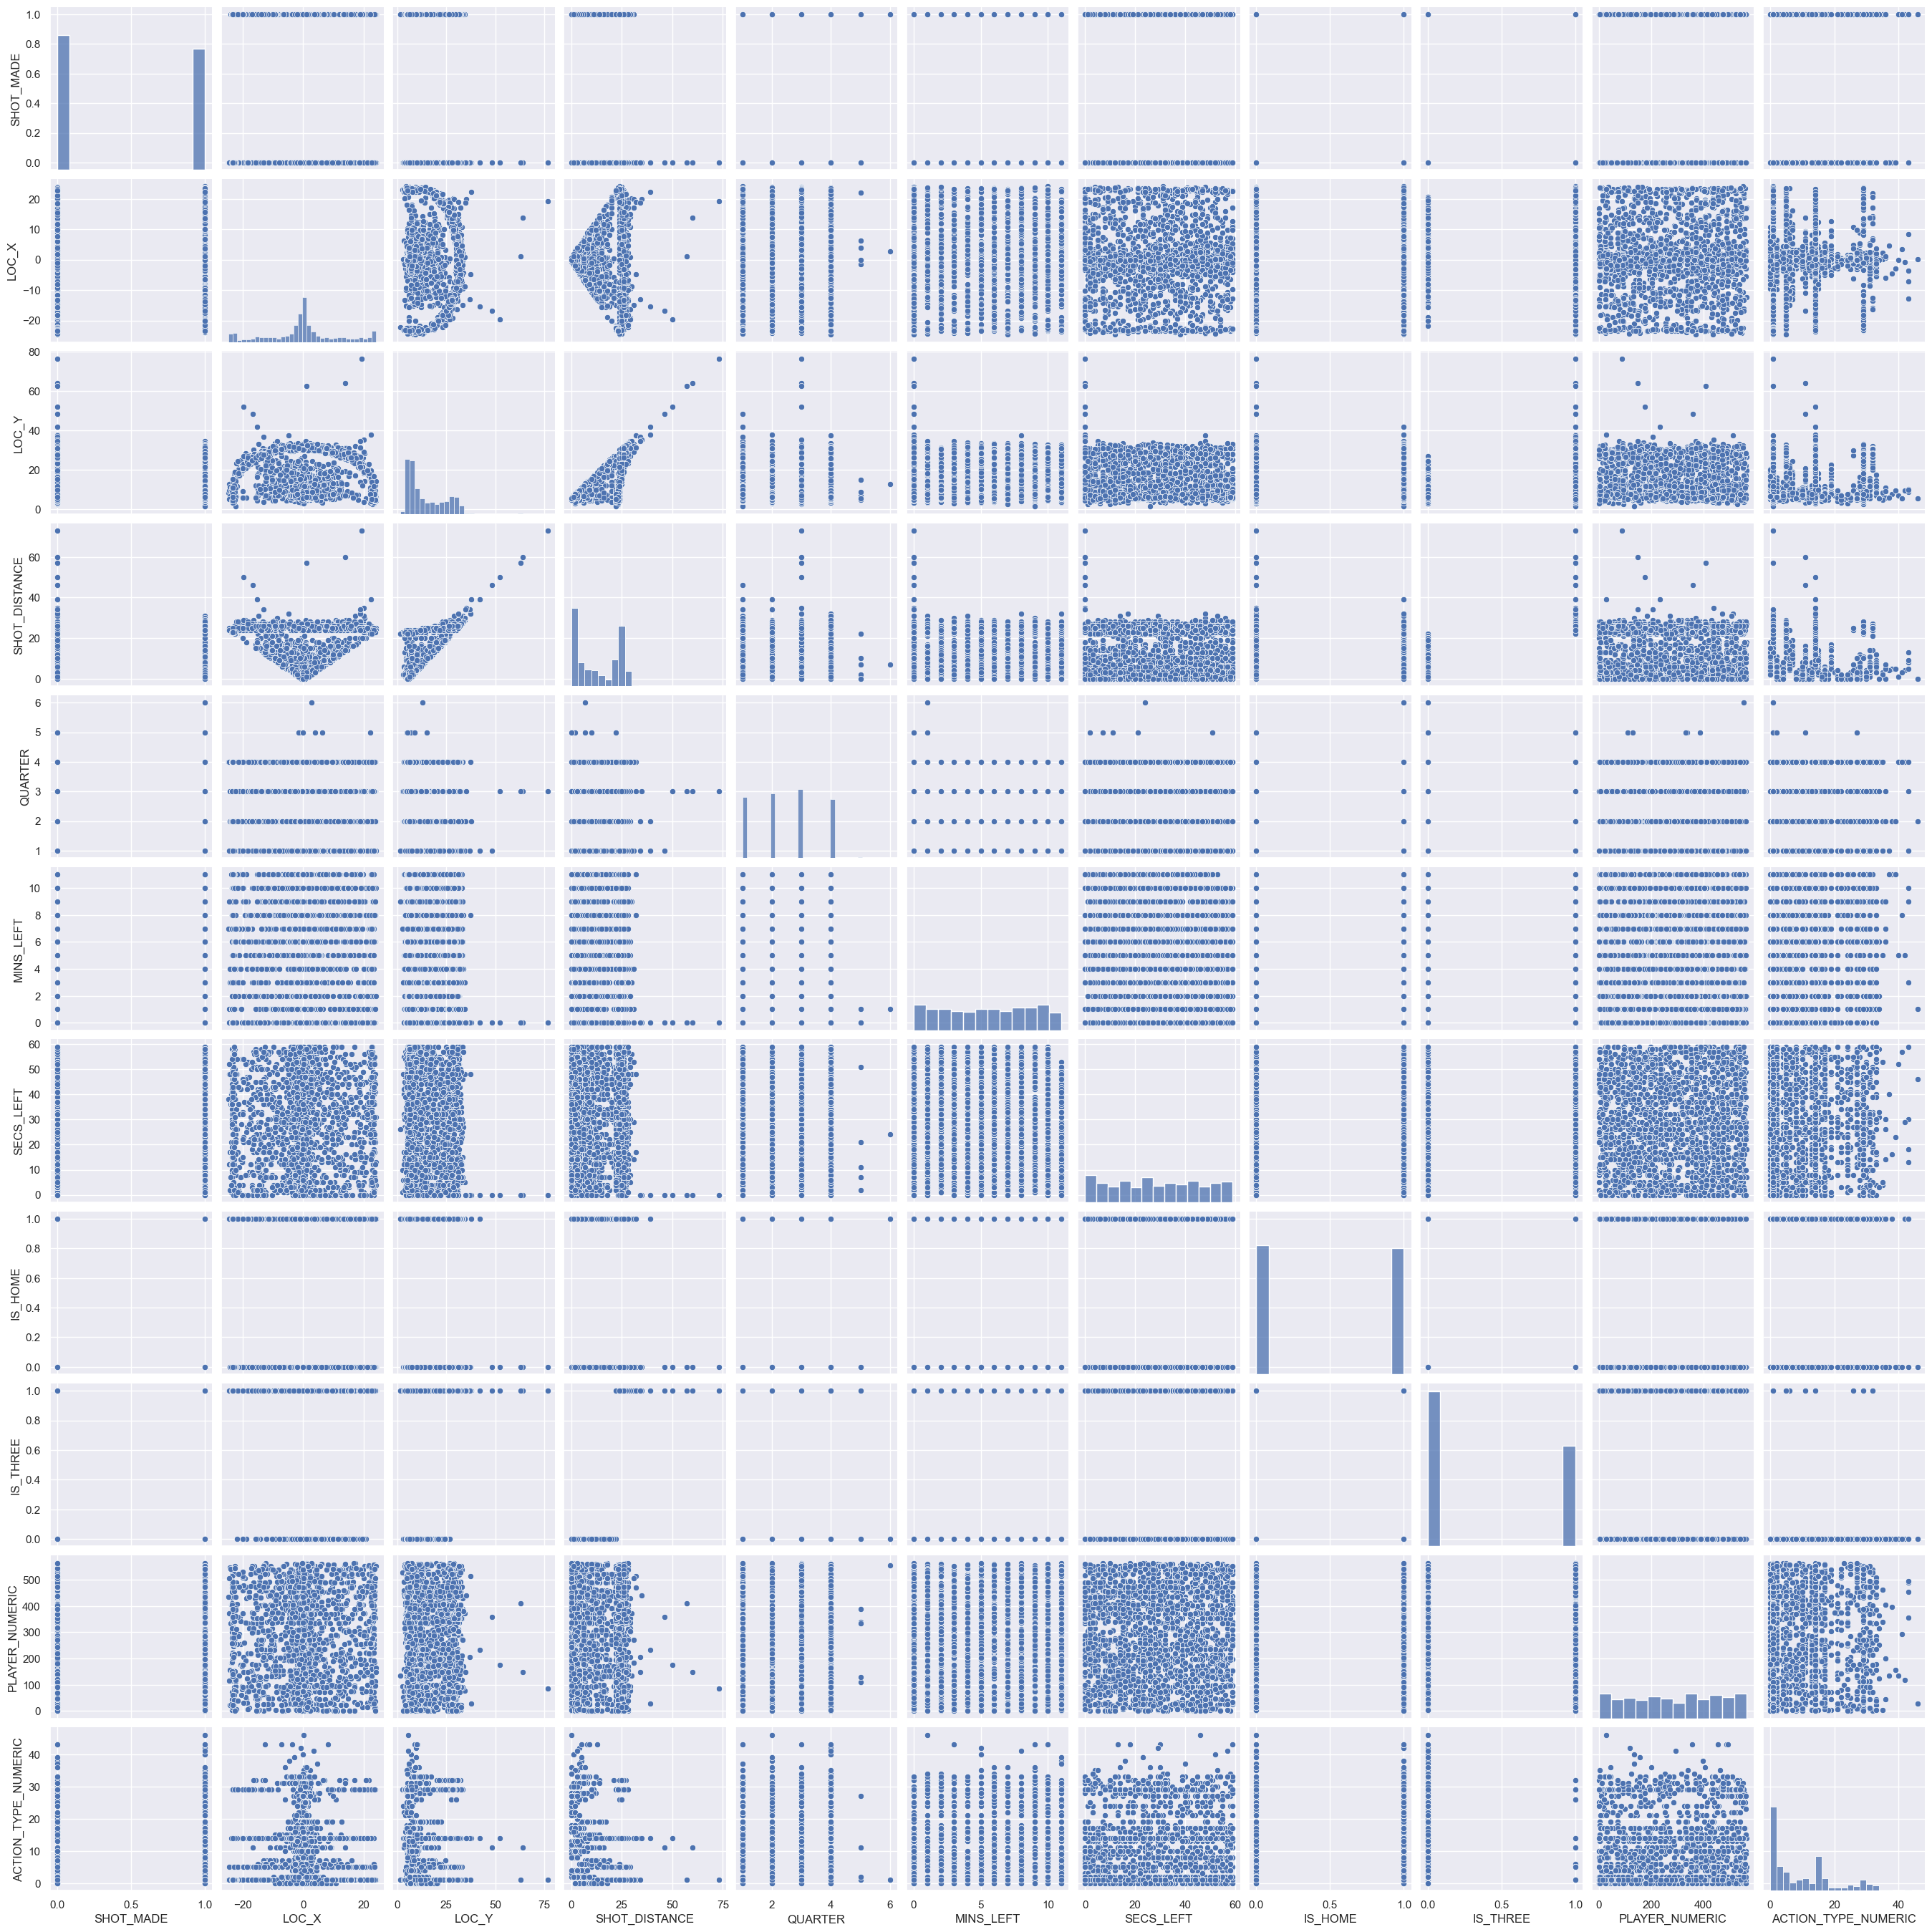

In [93]:
sns.pairplot(df2024.iloc[:,:9].sample(2000))

### Merged

In [150]:
df_merged.iloc[:,:10].corr()

YEAR  SHOT_MADE     LOC_X     LOC_Y  SHOT_DISTANCE  \
YEAR           1.000000   0.035741 -0.004621  0.148407       0.095162   
SHOT_MADE      0.035741   1.000000 -0.003685 -0.151089      -0.200485   
LOC_X         -0.004621  -0.003685  1.000000 -0.008156       0.023974   
LOC_Y          0.148407  -0.151089 -0.008156  1.000000       0.771940   
SHOT_DISTANCE  0.095162  -0.200485  0.023974  0.771940       1.000000   
QUARTER        0.003209  -0.012875  0.000927  0.010345       0.013465   
MINS_LEFT      0.006208   0.019763 -0.001270 -0.033751      -0.031394   
SECS_LEFT      0.005639   0.013914  0.002722 -0.036177      -0.032111   
IS_HOME       -0.001992   0.009654 -0.008382 -0.010256      -0.011795   
IS_THREE       0.226594  -0.127538  0.023104  0.596564       0.798843   

                QUARTER  MINS_LEFT  SECS_LEFT   IS_HOME  IS_THREE  
YEAR           0.003209   0.006208   0.005639 -0.001992  0.226594  
SHOT_MADE     -0.012875   0.019763   0.013914  0.009654 -0.127538  
LOC_X          0.000927  -0.001270   0.002722 -0.008382  0.023104  
LOC_Y          0.010345  -0.033751  -0.036177 -0.010256  0.596564  
SHOT_DISTANCE  0.013465  -0.031394  -0.032111 -0.011795  0.798843  
QUARTER        1.000000  -0.019947   0.003443 -0.001726  0.029081  
MINS_LEFT     -0.019947   1.000000   0.003526  0.001923 -0.037803  
SECS_LEFT      0.003443   0.003526   1.000000  0.000300 -0.021546  
IS_HOME       -0.001726   0.001923   0.000300  1.000000  0.000110  
IS_THREE       0.029081  -0.037803  -0.021546  0.000110  1.000000

<Axes: >

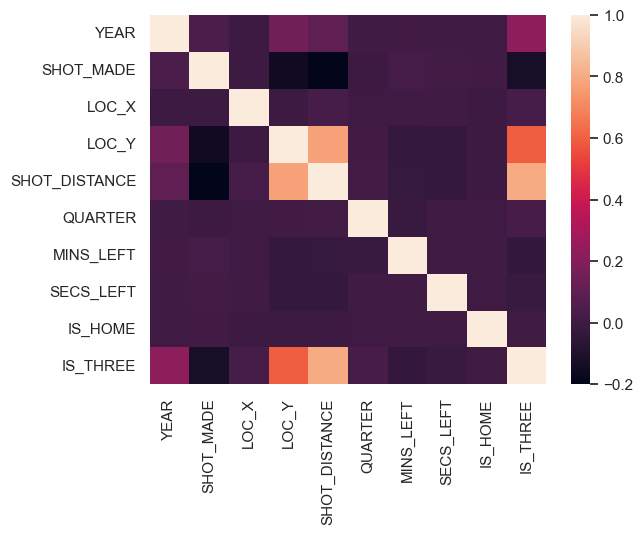

In [151]:
sns.heatmap(df_merged.iloc[:,:10].corr())

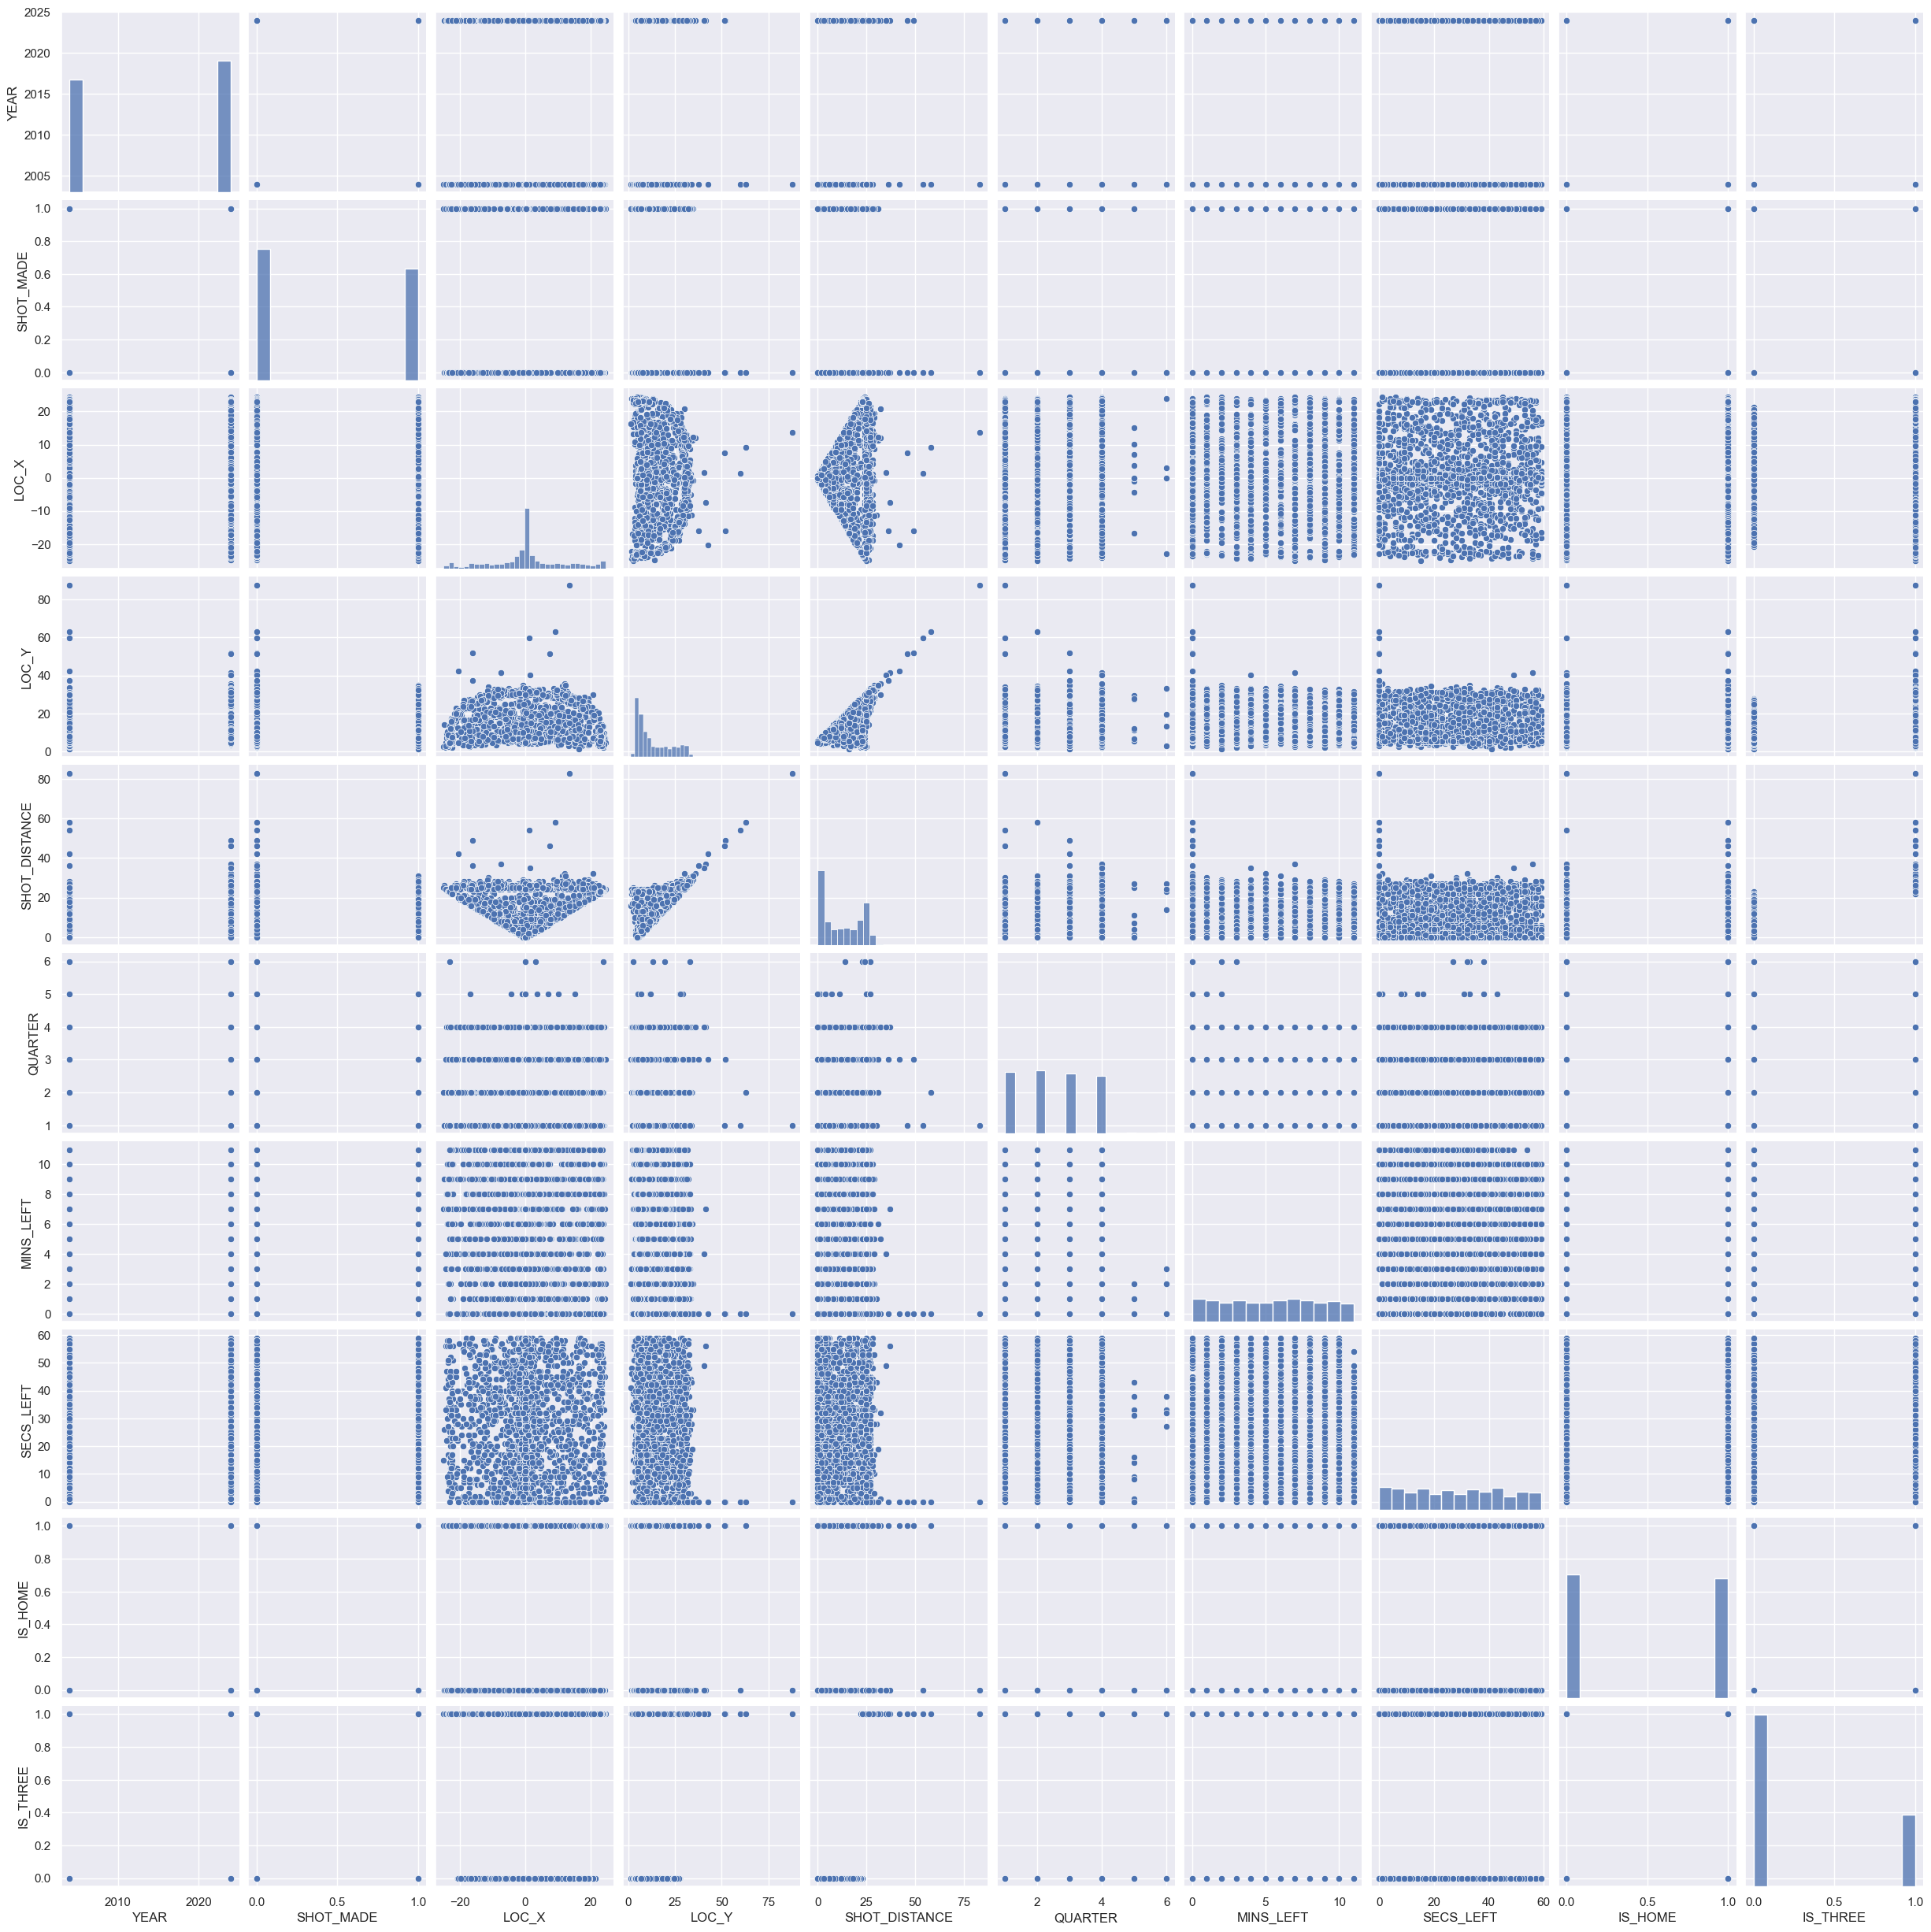

In [152]:
sns.pairplot(df_merged.iloc[:,:10].sample(2000))

The heatmaps show that there is a strong correlation between LOC_Y and SHOT_DISTANCE, which makes sense because LOC_Y is how far away from the baseline the shot was taken. Both of these also have a strong correlation with IS_THREE, which again makes sense because shots from further away will tend to be 3-pointers (it's not a uniform distance because the 3-point line is closer at the corners than at the middle). SHOT_MADE has a negative correlation with IS_THREE, LOC_Y, and SHOT_DISTANCE which is because longer shots will have a lower make rate than shots from up close. Finally, the merged heatmap shows a correlation between YEAR and IS_THREE, which aligns with my expectation that 2024 had more 3-point attempts than 2004.

The pairplots tell a similiar story, as the same relationships can be seen there as well. The pairplot for LOC_X vs LOC_Y shows the outline of the basketball court, which I didn't expect but it makes sense.

The QUARTER, MINS_LEFT, and SECS_LEFT appear to be pretty noisy at the moment. I was hoping that they would be useful in helping to determine if shots towards the end of the game tended to be makes or misses, but based on these graphs it doesn't look like they'll provide too much value to the model.

Overall, the best predictor based on these graphs for SHOT_MADE is SHOT_DISTANCE since it has the highest correlation value (a negative correlation since shots taken from further away have a lower make rate). However, I think that the PLAYER_NAME dummies will also prove to be highly useful, although they are not represented in the correlation plots.

## Logistic Regression

First I'll split the datasets into X and y training and test data by using test_train_split() with a test_size of 25%.

In [156]:
X_2004 = df2004.drop(['SHOT_MADE'], axis = 1)
Y_2004 = df2004['SHOT_MADE']

X_2024 = df2024.drop(['SHOT_MADE'], axis = 1)
Y_2024 = df2024['SHOT_MADE']

X_merged = df_merged.drop(['SHOT_MADE'], axis = 1)
Y_merged = df_merged['SHOT_MADE']

(x_2004_train, x_2004_test, y_2004_train, y_2004_test) = train_test_split(X_2004, Y_2004, random_state = 5, test_size = .25)
(x_2024_train, x_2024_test, y_2024_train, y_2024_test) = train_test_split(X_2024, Y_2024, random_state = 5, test_size = .25)
(x_merged_train, x_merged_test, y_merged_train, y_merged_test) = train_test_split(X_merged, Y_merged, random_state = 5, test_size = .25)

Now I'll use a Logistic Regression model and look at its ROC curve as well as its precision, accuracy, recall, and confusion matrix.

## 2004

AUC: 0.6662141828375807
Accuracy Score 0.637626182799098
Precision Score 0.6146061098269507
Recall Score 0.4715299079754601


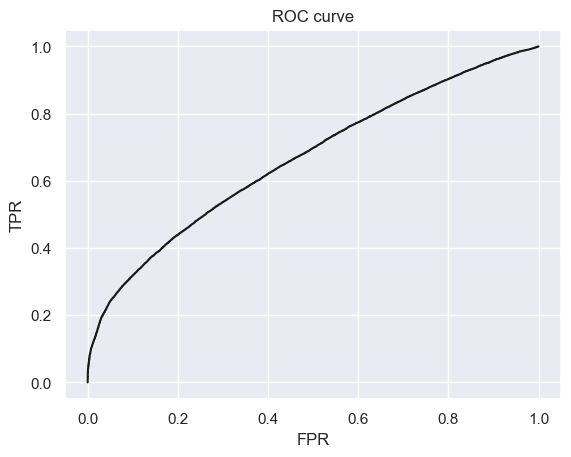

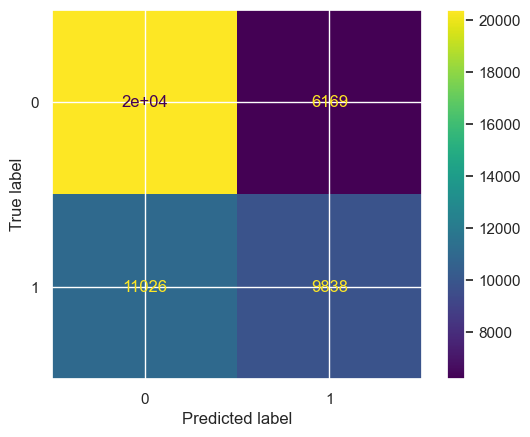

In [201]:
logreg_2004 = LogisticRegression(class_weight='balanced', solver='liblinear').fit(x_2004_train, y_2004_train)

# Create the ROC curve plot
y_2004_proba = logreg_2004.predict_proba(x_2004_test)

fpr, tpr, th = roc_curve(y_2004_test, y_2004_proba[:, 1])
auc = roc_auc_score(y_2004_test, y_2004_proba[:, 1])
print(f'AUC: {auc}')
plt.plot(fpr, tpr, 'k-')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

# Predict the test data and get the accuracy and precision scores
y_2004_pred = logreg_2004.predict(x_2004_test)

print(f'Accuracy Score {accuracy_score(y_2004_test, y_2004_pred)}')
print(f'Precision Score {precision_score(y_2004_test, y_2004_pred)}')
print(f'Recall Score {recall_score(y_2004_test, y_2004_pred)}')

ConfusionMatrixDisplay(confusion_matrix(y_2004_test, y_2004_pred)).plot()

## 2024

AUC: 0.6494136601198442
Accuracy Score 0.6153705464920624
Precision Score 0.6156070734366852
Recall Score 0.5012158875979466


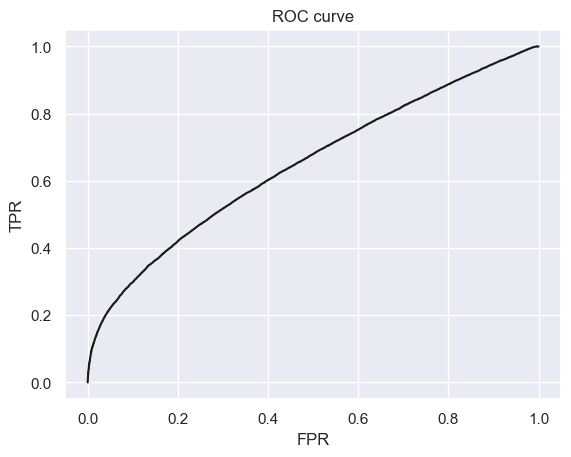

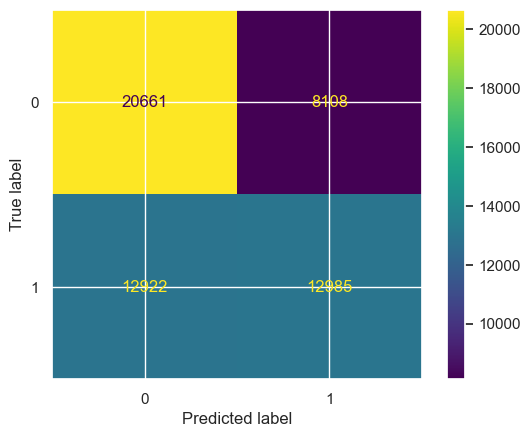

In [195]:
logreg_2024 = LogisticRegression(class_weight='balanced', solver='liblinear').fit(x_2024_train, y_2024_train)

# Create the ROC curve plot
y_2024_proba = logreg_2024.predict_proba(x_2024_test)

fpr, tpr, th = roc_curve(y_2024_test, y_2024_proba[:, 1])
auc = roc_auc_score(y_2024_test, y_2024_proba[:, 1])
print(f'AUC: {auc}')
plt.plot(fpr, tpr, 'k-')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

# Predict the test data and get the accuracy and precision scores
y_2024_pred = logreg_2024.predict(x_2024_test)

print(f'Accuracy Score {accuracy_score(y_2024_test, y_2024_pred)}')
print(f'Precision Score {precision_score(y_2024_test, y_2024_pred)}')
print(f'Recall Score {recall_score(y_2024_test, y_2024_pred)}')

ConfusionMatrixDisplay(confusion_matrix(y_2024_test, y_2024_pred)).plot()

## Merged

AUC: 0.6451933057240749
Accuracy Score 0.6196659029042555
Precision Score 0.6073217930705406
Recall Score 0.4880802743986877


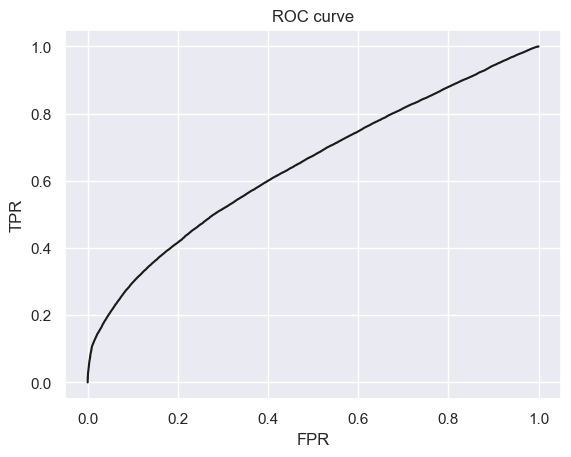

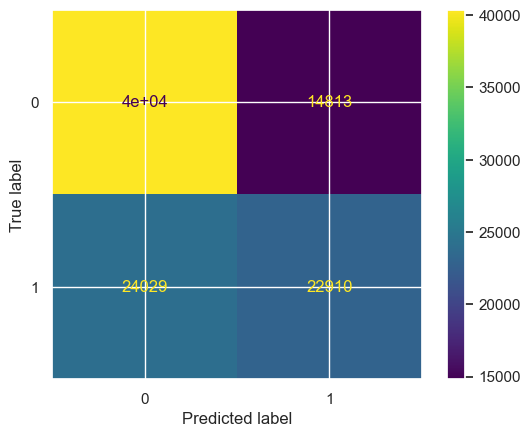

In [196]:
logreg_merged = LogisticRegression(class_weight='balanced', solver='liblinear').fit(x_merged_train, y_merged_train)

# Create the ROC curve plot
y_merged_proba = logreg_merged.predict_proba(x_merged_test)

fpr, tpr, th = roc_curve(y_merged_test, y_merged_proba[:, 1])
auc = roc_auc_score(y_merged_test, y_merged_proba[:, 1])
print(f'AUC: {auc}')
plt.plot(fpr, tpr, 'k-')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

# Predict the test data and get the accuracy and precision scores
y_merged_pred = logreg_merged.predict(x_merged_test)

print(f'Accuracy Score {accuracy_score(y_merged_test, y_merged_pred)}')
print(f'Precision Score {precision_score(y_merged_test, y_merged_pred)}')
print(f'Recall Score {recall_score(y_merged_test, y_merged_pred)}')

ConfusionMatrixDisplay(confusion_matrix(y_merged_test, y_merged_pred)).plot()

These models all have the accuracy and precision scores in the low 60%s and recall around 50%, which indicates that this is not a good fit for the data. A recall score below 50% in especially poor for a binary classification problem like this, since it means it's performing worse than just random guessing. I think the large number of PLAYER_NAME dummies is having an adverse effect on the model, but simply dropping those columns would lose too much information for the model to be relevant.

## KNN
I do not think KNN will be a good classifier, since this amplifies the issue with the PLAYER_NAME dummies, but maybe there's something to gleam from it.

### 2004

AUC: 0.5805306131857075
Accuracy Score 0.5768476955174812
Precision Score 0.5228662976988057
Recall Score 0.4301667944785276


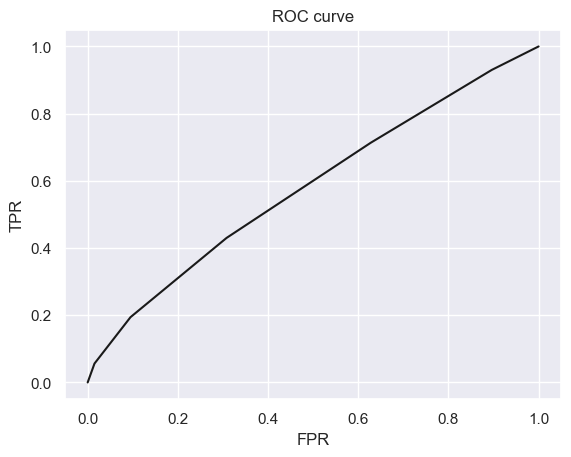

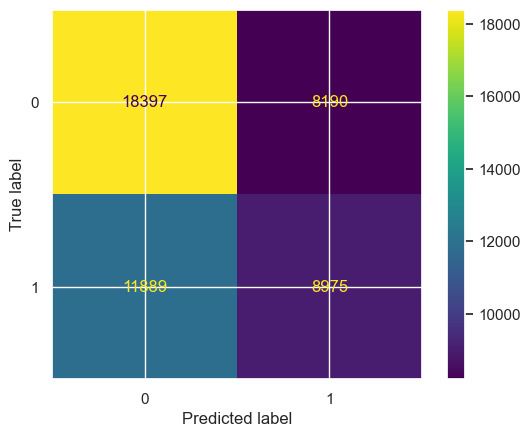

In [202]:
knn_2004 = KNeighborsClassifier().fit(x_2004_train, y_2004_train)

# Create the ROC curve plot
y_2004_proba = knn_2004.predict_proba(x_2004_test)

fpr, tpr, th = roc_curve(y_2004_test, y_2004_proba[:, 1])
auc = roc_auc_score(y_2004_test, y_2004_proba[:, 1])
print(f'AUC: {auc}')
plt.plot(fpr, tpr, 'k-')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

# Predict the test data and get the accuracy and precision scores
y_2004_pred = knn_2004.predict(x_2004_test)

print(f'Accuracy Score {accuracy_score(y_2004_test, y_2004_pred)}')
print(f'Precision Score {precision_score(y_2004_test, y_2004_pred)}')
print(f'Recall Score {recall_score(y_2004_test, y_2004_pred)}')

ConfusionMatrixDisplay(confusion_matrix(y_2004_test, y_2004_pred)).plot()

As suspected, this is not a good fit either and performs about as well Logistic Regression. I'm not going to run this for the 2024 or merged dataset since this took a while to run on my computer.

## Decision Tree

A decision tree might perform better than the other classifiers. I want to encourage the tree to make decisions on the PLAYER_NAME dummies, so a very wide tree should help with that, so I will not specify a max_leaf_nodes value. Unfortunately reducing the number of max_features will likely lead to trees that only have our PLAYER_NAME dummies, since the number of dummies dwarfs the number of other features in the dataset.

AUC: 0.5680184899396148
Accuracy Score 0.5779224884617816
Precision Score 0.5215597276665979
Recall Score 0.48466257668711654


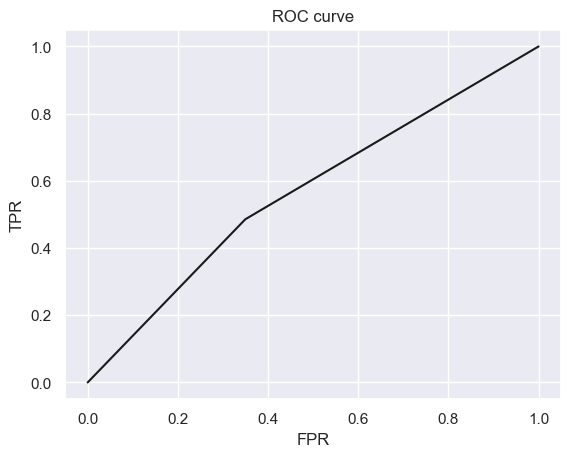

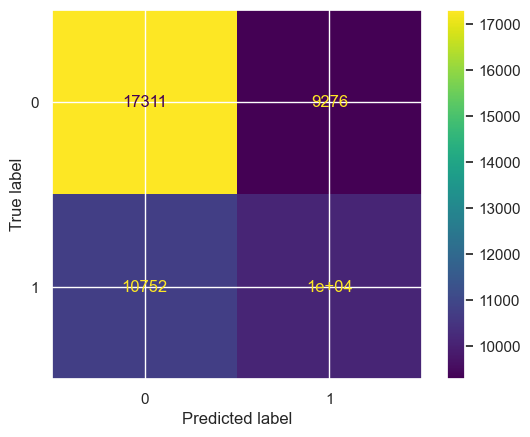

In [203]:
tree_2004 = DecisionTreeClassifier().fit(x_2004_train, y_2004_train)

# Create the ROC curve plot
y_2004_proba = tree_2004.predict_proba(x_2004_test)

fpr, tpr, th = roc_curve(y_2004_test, y_2004_proba[:, 1])
auc = roc_auc_score(y_2004_test, y_2004_proba[:, 1])
print(f'AUC: {auc}')
plt.plot(fpr, tpr, 'k-')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

# Predict the test data and get the accuracy and precision scores
y_2004_pred = tree_2004.predict(x_2004_test)

print(f'Accuracy Score {accuracy_score(y_2004_test, y_2004_pred)}')
print(f'Precision Score {precision_score(y_2004_test, y_2004_pred)}')
print(f'Recall Score {recall_score(y_2004_test, y_2004_pred)}')

ConfusionMatrixDisplay(confusion_matrix(y_2004_test, y_2004_pred)).plot()

## 2024

AUC: 0.5614152413284511
Accuracy Score 0.5635379325481016
Precision Score 0.5409500901984365
Recall Score 0.5208630871965106


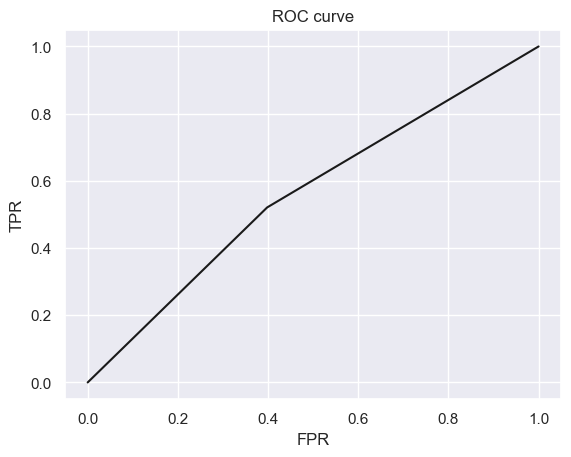

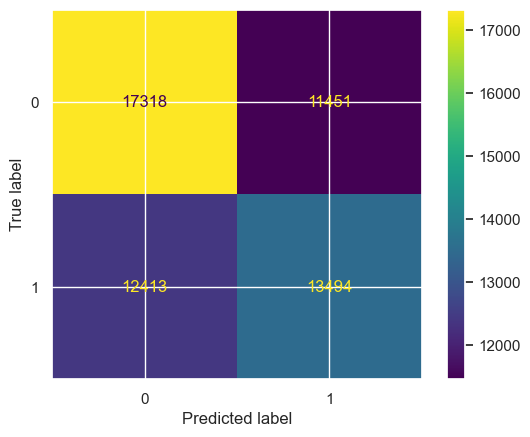

In [204]:
tree_2024 = DecisionTreeClassifier().fit(x_2024_train, y_2024_train)

# Create the ROC curve plot
y_2024_proba = tree_2024.predict_proba(x_2024_test)

fpr, tpr, th = roc_curve(y_2024_test, y_2024_proba[:, 1])
auc = roc_auc_score(y_2024_test, y_2024_proba[:, 1])
print(f'AUC: {auc}')
plt.plot(fpr, tpr, 'k-')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

# Predict the test data and get the accuracy and precision scores
y_2024_pred = tree_2024.predict(x_2024_test)

print(f'Accuracy Score {accuracy_score(y_2024_test, y_2024_pred)}')
print(f'Precision Score {precision_score(y_2024_test, y_2024_pred)}')
print(f'Recall Score {recall_score(y_2024_test, y_2024_pred)}')

ConfusionMatrixDisplay(confusion_matrix(y_2024_test, y_2024_pred)).plot()

## Merged

AUC: 0.5696038314316848
Accuracy Score 0.5744962105634217
Precision Score 0.5393334537572254
Recall Score 0.5088732184324336


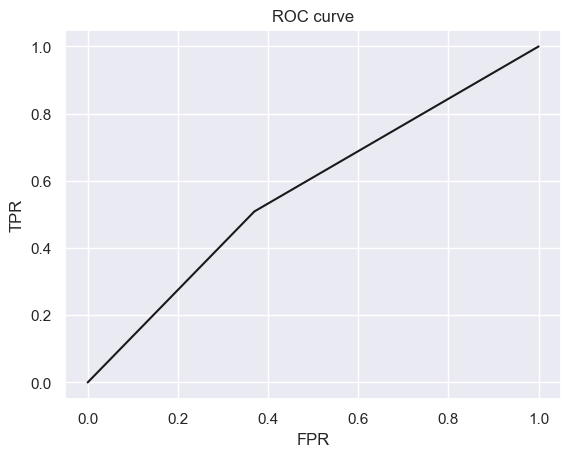

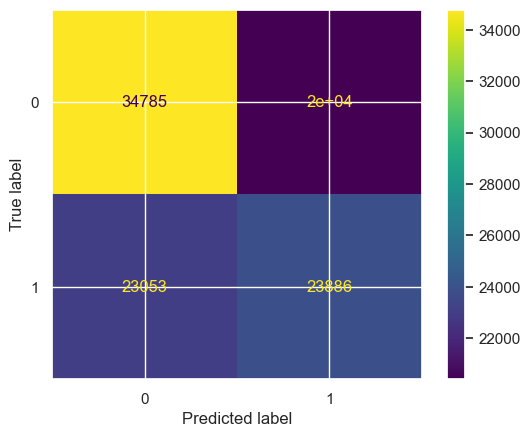

In [205]:
tree_merged = DecisionTreeClassifier().fit(x_merged_train, y_merged_train)

# Create the ROC curve plot
y_merged_proba = tree_merged.predict_proba(x_merged_test)

fpr, tpr, th = roc_curve(y_merged_test, y_merged_proba[:, 1])
auc = roc_auc_score(y_merged_test, y_merged_proba[:, 1])
print(f'AUC: {auc}')
plt.plot(fpr, tpr, 'k-')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

# Predict the test data and get the accuracy and precision scores
y_merged_pred = tree_merged.predict(x_merged_test)

print(f'Accuracy Score {accuracy_score(y_merged_test, y_merged_pred)}')
print(f'Precision Score {precision_score(y_merged_test, y_merged_pred)}')
print(f'Recall Score {recall_score(y_merged_test, y_merged_pred)}')

ConfusionMatrixDisplay(confusion_matrix(y_merged_test, y_merged_pred)).plot()

The Decision Tree did not perform better than Logistic Regression, and the large number of misclassifications in the confusion matrices helps to spotlight that. It still seems these models are not doing much better than randomly guessing.

## AdaBoost
Lastly, I want to try an AdaBoostClassifier using a DecisionTree as the base classifier. Unfortuantely experiementing with different values for max_features will likely result in many trees having only PLAYER_NAME dummies in their feature sets, which will not make a useful model. I will experiement with different values of max_depth for the base DecisionTree, as well as the number of base estimators.

### 2004 (max_depth = 1, n_estimators = 50)

AUC: 0.6718076036644715
Accuracy Score 0.6459505595245622
Precision Score 0.70051312413657
Recall Score 0.34025115030674846


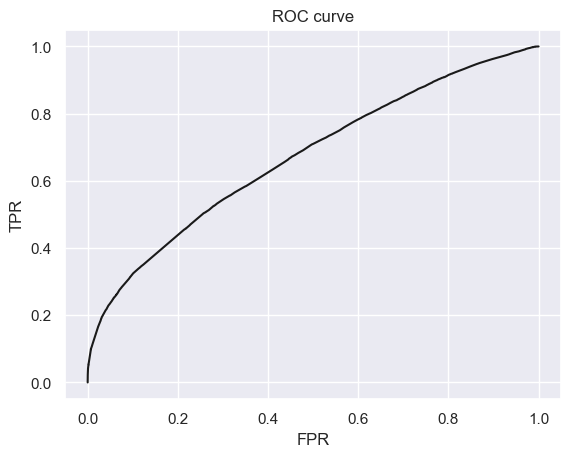

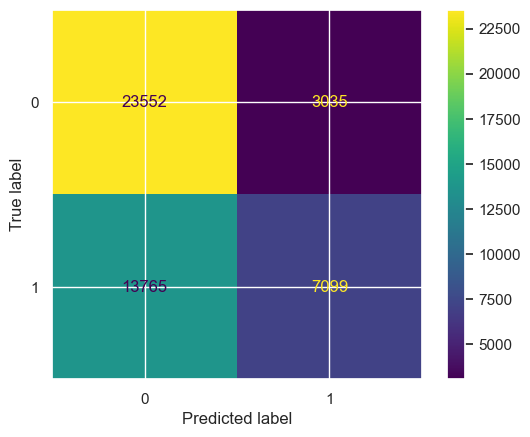

In [208]:
max_depth = 1
n_estimators = 50

adaboost_2004 = AdaBoostClassifier(DecisionTreeClassifier(max_depth = max_depth), n_estimators = n_estimators).fit(x_2004_train, y_2004_train)

# Create the ROC curve plot
y_2004_proba = adaboost_2004.predict_proba(x_2004_test)

fpr, tpr, th = roc_curve(y_2004_test, y_2004_proba[:, 1])
auc = roc_auc_score(y_2004_test, y_2004_proba[:, 1])
print(f'AUC: {auc}')
plt.plot(fpr, tpr, 'k-')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

# Predict the test data and get the accuracy and precision scores
y_2004_pred = adaboost_2004.predict(x_2004_test)

print(f'Accuracy Score {accuracy_score(y_2004_test, y_2004_pred)}')
print(f'Precision Score {precision_score(y_2004_test, y_2004_pred)}')
print(f'Recall Score {recall_score(y_2004_test, y_2004_pred)}')

ConfusionMatrixDisplay(confusion_matrix(y_2004_test, y_2004_pred)).plot()

### 2004 (max_depth = 3, n_estimators = 50)

AUC: 0.6718875560839618
Accuracy Score 0.6478472529556806
Precision Score 0.6879297864639884
Recall Score 0.3644075920245399


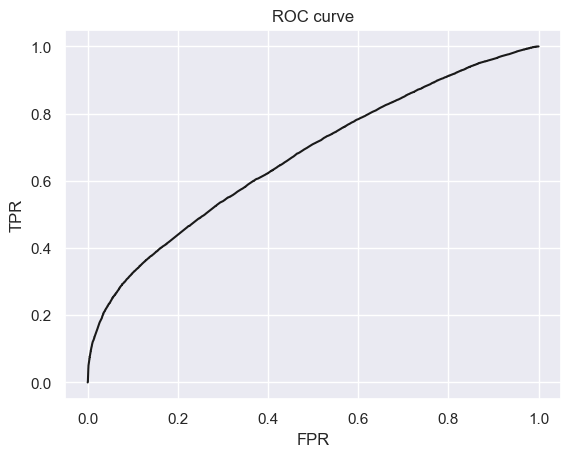

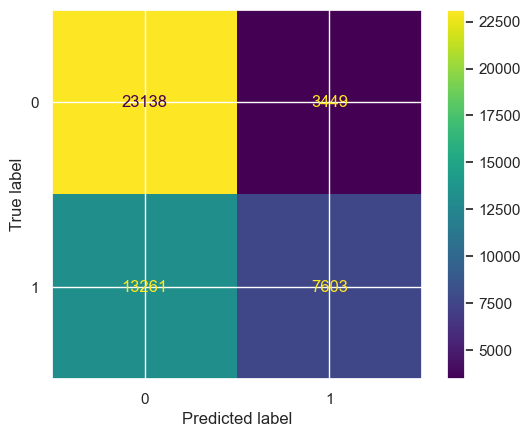

In [209]:
max_depth = 3
n_estimators = 50

adaboost_2004 = AdaBoostClassifier(DecisionTreeClassifier(max_depth = max_depth), n_estimators = n_estimators).fit(x_2004_train, y_2004_train)

# Create the ROC curve plot
y_2004_proba = adaboost_2004.predict_proba(x_2004_test)

fpr, tpr, th = roc_curve(y_2004_test, y_2004_proba[:, 1])
auc = roc_auc_score(y_2004_test, y_2004_proba[:, 1])
print(f'AUC: {auc}')
plt.plot(fpr, tpr, 'k-')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

# Predict the test data and get the accuracy and precision scores
y_2004_pred = adaboost_2004.predict(x_2004_test)

print(f'Accuracy Score {accuracy_score(y_2004_test, y_2004_pred)}')
print(f'Precision Score {precision_score(y_2004_test, y_2004_pred)}')
print(f'Recall Score {recall_score(y_2004_test, y_2004_pred)}')

ConfusionMatrixDisplay(confusion_matrix(y_2004_test, y_2004_pred)).plot()

## 2004 (max_depth = 5, n_estimators = 100)

AUC: 0.658025763779106
Accuracy Score 0.6378158521422098
Precision Score 0.637856071964018
Recall Score 0.4078316717791411


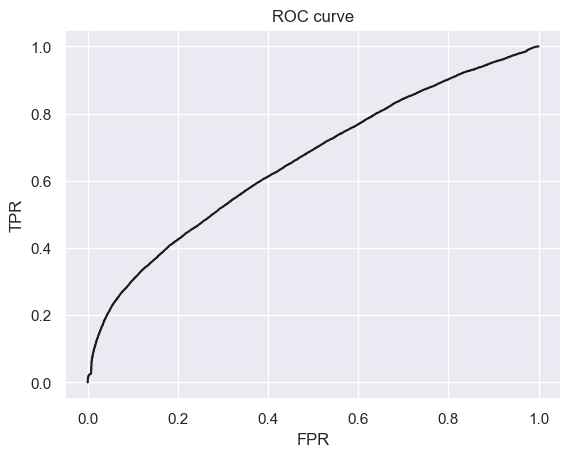

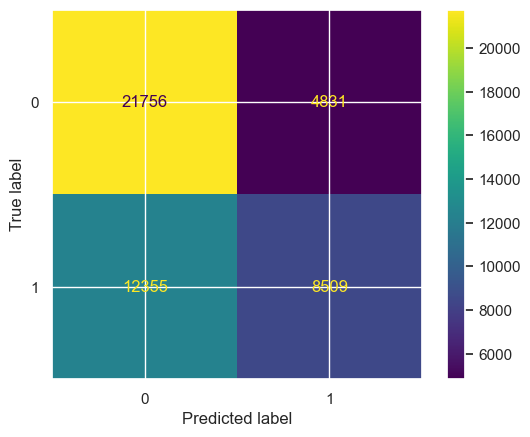

In [210]:
max_depth = 5
n_estimators = 100

adaboost_2004 = AdaBoostClassifier(DecisionTreeClassifier(max_depth = max_depth), n_estimators = n_estimators).fit(x_2004_train, y_2004_train)

# Create the ROC curve plot
y_2004_proba = adaboost_2004.predict_proba(x_2004_test)

fpr, tpr, th = roc_curve(y_2004_test, y_2004_proba[:, 1])
auc = roc_auc_score(y_2004_test, y_2004_proba[:, 1])
print(f'AUC: {auc}')
plt.plot(fpr, tpr, 'k-')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

# Predict the test data and get the accuracy and precision scores
y_2004_pred = adaboost_2004.predict(x_2004_test)

print(f'Accuracy Score {accuracy_score(y_2004_test, y_2004_pred)}')
print(f'Precision Score {precision_score(y_2004_test, y_2004_pred)}')
print(f'Recall Score {recall_score(y_2004_test, y_2004_pred)}')

ConfusionMatrixDisplay(confusion_matrix(y_2004_test, y_2004_pred)).plot()

At first the AdaBoostClassifiers looked to be more promising since it had higher AUC, precision, and accuracy, however the extremely low recall and the confusion matrices help to show the complete picture. The model is over predicting missed shots, as evidenced by the 12 thousand false negatives compared to the less than 5 thousand false positivies.

## AdaBoost (No Dummies)
By this point I've come to the conclusion that while the player taking the shot is an important factor, I think the PLAYER_NAME dummies are making the data difficult to model. I want to try an AdaBoost with a limited set of features that does not include the PLAYER_NAME and ACTION_TYPE dummies, as well as the QUARTER, MINS_LEFT, and SECS_LEFT since those are not highly relevant features. I'll also remove SHOT_DISTANCE and IS_THREE since those are highly correlated with LOC_Y. This will be predicting the outcome of the shot based on the location of the shot, and whether or not the shot was taken in a home game.

AUC: 0.6054634643663782
Accuracy Score 0.6167836294282523
Precision Score 0.6005402160864346
Recall Score 0.3836273006134969


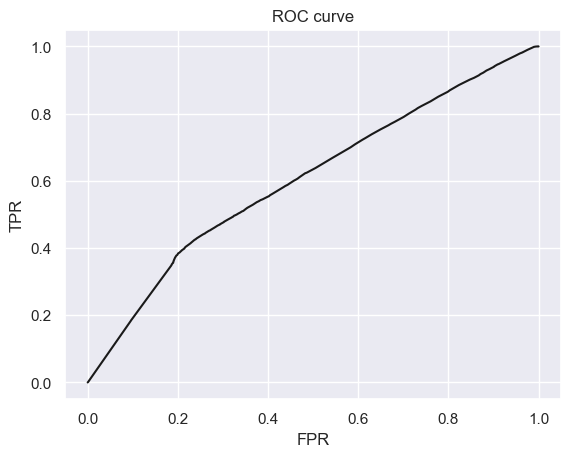

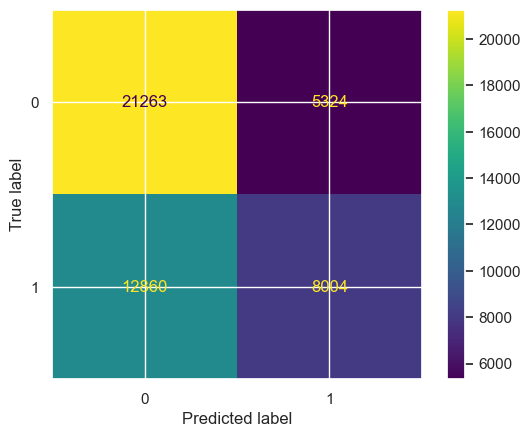

In [225]:
# Drop extra features
df2004_reduced = df2004_original.drop(['PLAYER_NAME', 'ACTION_TYPE', 'SHOT_DISTANCE', 'QUARTER', 'MINS_LEFT', 'SECS_LEFT', 'IS_THREE'], axis = 1)

df2004_reduced.head()

# Split the reduced dataset into train and test sets
X_2004_reduced = df2004_reduced.drop(['SHOT_MADE'], axis = 1)
Y_2004_reduced = df2004_reduced['SHOT_MADE']
(x_2004_reduced_train, x_2004_reduced_test, y_2004_reduced_train, y_2004_reduced_test) = train_test_split(X_2004_reduced, Y_2004_reduced, random_state = 5, test_size = .25)

# Run AdaClassifier with max_depth = 1, n_estimators = 50
max_depth = 1
n_estimators = 50

adaboost_2004_reduced = AdaBoostClassifier(DecisionTreeClassifier(max_depth = max_depth), n_estimators = n_estimators).fit(x_2004_reduced_train, y_2004_reduced_train)

# Create the ROC curve plot
y_2004_reduced_proba = adaboost_2004_reduced.predict_proba(x_2004_reduced_test)

fpr, tpr, th = roc_curve(y_2004_reduced_test, y_2004_reduced_proba[:, 1])
auc = roc_auc_score(y_2004_reduced_test, y_2004_reduced_proba[:, 1])
print(f'AUC: {auc}')
plt.plot(fpr, tpr, 'k-')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

# Predict the test data and get the accuracy and precision scores
y_2004_reduced_pred = adaboost_2004_reduced.predict(x_2004_reduced_test)

print(f'Accuracy Score {accuracy_score(y_2004_reduced_test, y_2004_reduced_pred)}')
print(f'Precision Score {precision_score(y_2004_reduced_test, y_2004_reduced_pred)}')
print(f'Recall Score {recall_score(y_2004_reduced_test, y_2004_reduced_pred)}')

ConfusionMatrixDisplay(confusion_matrix(y_2004_reduced_test, y_2004_reduced_pred)).plot()

The results of this model were not that much better than the other models. I think there are too few features here for the model to be meaningful.

## Conclusion
None of these models were very robust. I think this stems largely from a couple of issues inherent to the data and the scope of the project. Shots in basketball have a high amount of variance - the same player can take the same shot twice from the same spot on the court in the same game and make it the first time and miss it the second. There's no factor that exists that can be used to explain why the shot went in the first time and not the second - the player just shot better the first time. There is also a large amount of variance between players - good shooters like Steve Nash or Dirk Nowitzki can be expected to have much higher made shot rates than other lesser skilled players. Therefore we can't exclude the player from a model like this, but there does not seem to be a good way to model it here (at least, based on my knowledge and what we've covered in this class). The large number of dummy columns just overwhelm everything else. I think if I were starting this project again, I would instead take data for 1 player across multiple seasons rather than looking at data for all players. I think the ACTION_TYPE, which describes the type of shot, is an important feature, but it also has a large number of values (around 60), which would lead to a large number of dummy columns. A more thorough data cleaning might be used to combine several different values together to reduce the number of dummies necessary. There might also be a better way than using dummies to model this type of data - maybe we'll learn about such methods in the next class!